# Introduction

We have been given a dataset containing the data of images of wells, the wells are ordered in columns and rows into the well plate. The wells contain bacteria that react with gold and change their color accordingly, we want to predict the gold concentration of wells. The dataset features are many and relating the well positioning, the camera settings and the "image channel" settings. The labels are `class_target`, that is the "class of concentration", and the `value_target`, that is the concentration of gol itself.

The unit of measure of concentration in `class_target` used is "CFU/ml". CFU stands for Colony Forming Units, which is a measure used in microbiology to estimate the number of viable bacteria or fungal cells in a sample. It's not a direct measurement of the total quantity of bacteria, but rather a measure of the number of cells capable of dividing and forming colonies.In simple words, it is the number of "units of bacteria" capable of forming colonies, therefore "CFU/ml" it's "units of bacteria capable of forming colonies in a milliliter of liquid".

In [1]:
import pandas as pd

df = pd.read_pickle('df.pkl')

We define some utils

In [2]:
from utils import print_full_classification_report, print_full_regression_report, create_training_history_plot

# Dataset analysis and simplification

We notice that most features are numeric, we ask ourselves if we can perform training on a dataset with only numeric features.

In [12]:
LABEL_COLUMNS = ['class_target', 'value_target']
FEATURES_COLUMNS = [col for col in df.columns if col not in LABEL_COLUMNS]

# Print numeric features and one example value using pd.api.types.is_numeric_dtype
NUMERICAL_FEATURES = [col for col in FEATURES_COLUMNS if pd.api.types.is_numeric_dtype(df[col])]
CATEGORICAL_FEATURES = [col for col in FEATURES_COLUMNS if col not in NUMERICAL_FEATURES]

print('Number of numeric features:', len(NUMERICAL_FEATURES))
print('Number of categorical features:', len(CATEGORICAL_FEATURES))
print(f'Total number of features: {len(NUMERICAL_FEATURES) + len(CATEGORICAL_FEATURES)}')
print(f'Percentage of categorical features: {len(CATEGORICAL_FEATURES) / len(df.columns) * 100}%')
print(f'Percentage of numeric features: {len(NUMERICAL_FEATURES) / len(df.columns) * 100}%')

print('Numeric features:')
for col in NUMERICAL_FEATURES:
    print(f'\t{col}: {df[col].iloc[0]}')

print('Categorical features:')
for col in CATEGORICAL_FEATURES:
    print(f'\t{col}: {df[col].iloc[0]}')

Number of numeric features: 167
Number of categorical features: 11
Total number of features: 178
Percentage of categorical features: 6.111111111111111%
Percentage of numeric features: 92.77777777777779%
Numeric features:
	wp_image_prop: 0.0
	mock: False
	FocalLengthIn35mmFilm: 0.0
	ISOSpeedRatings: 226.0
	Orientation: 1.0
	Flash: 16.0
	MeteringMode: 2.0
	full_gray_mean: 76.37894375857339
	full_gray_stddev: 42.19194116854811
	full_gray_mean_trm30: 89.51971710244321
	full_gray_skewness: -0.985075922379453
	full_gray_entropy: 4.823225765539228
	full_gray_entropy2: 3.3432053405876
	full_gray_entropy_glcm: 7.1244046874085125
	full_gray_mean_PIL: 76.37894375857339
	full_blue_mean: 66.73251028806584
	full_blue_stddev: 38.11588827465449
	full_blue_mean_trm30: 75.86755250750107
	full_blue_skewness: -0.7398326957511079
	full_blue_entropy: 4.923509474933315
	full_blue_entropy2: 3.4127167110102032
	full_blue_entropy_glcm: 7.267878672884646
	full_blue_mean_PIL: 66.73251028806584
	full_green_mean: 6

We decide to drop the categorical features, because we want to experiment if models trained on a dataset with only numeric features will be good enough.

In [25]:
# Drop categorical features
df_numeric = df.drop(columns=CATEGORICAL_FEATURES)

FEATURES_COLUMNS = [col for col in df_numeric.columns if col not in LABEL_COLUMNS]

We drop features with no variance, because they are useless

In [26]:
# Drop feature that are constant
CONSTANT_FEATURES = [col for col in FEATURES_COLUMNS if df_numeric[col].nunique() == 1]
df_numeric = df_numeric.drop(columns=CONSTANT_FEATURES)

FEATURES_COLUMNS = [col for col in df_numeric.columns if col not in LABEL_COLUMNS]

# Feature selection

We perform feature selection using different methods

### Correlation calculations

We calculate Pearson correlation between features and we drop the features

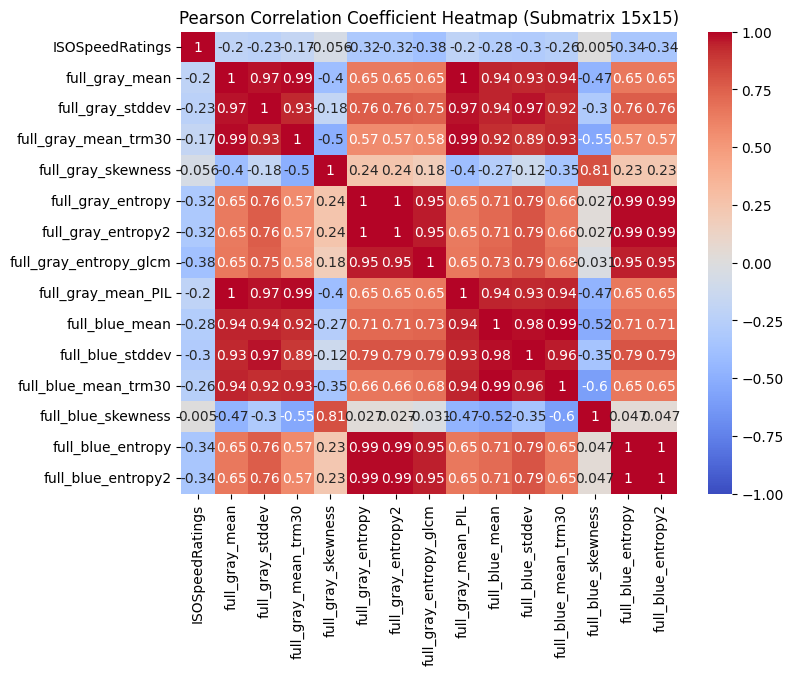

Dropped 147 columns with correlation coefficient above 0.8: {'red_stddev', 'full_blue_mean_PIL', 'H_mean_PIL', 'full_S_entropy', 'H_mean_trm30', 'L_skewness', 'full_S_entropy_glcm', 'full_gray_mean_trm30', 'full_blue_stddev', 'b_stddev', 'full_V_entropy', 'V_stddev', 'full_blue_mean_trm30', 'L_mean_PIL', 'green_skewness', 'full_gray_entropy2', 'full_H_stddev', 'green_entropy2', 'full_L_mean', 'H_stddev', 'gray_mean_PIL', 'b_skewness', 'V_entropy2', 'b_mean_PIL', 'full_V_entropy_glcm', 'blue_mean_trm30', 'full_green_skewness', 'full_red_mean_PIL', 'a_mean_trm30', 'blue_mean_PIL', 'full_a_entropy2', 'full_red_entropy2', 'full_S_entropy2', 'gray_entropy_glcm', 'green_mean_PIL', 'b_mean_trm30', 'full_green_mean_PIL', 'full_gray_stddev', 'green_mean', 'H_mean', 'a_mean', 'b_mean', 'full_L_entropy2', 'red_entropy', 'full_H_mean_PIL', 'red_mean_PIL', 'V_entropy', 'full_gray_mean_PIL', 'full_blue_entropy2', 'V_mean_trm30', 'full_green_entropy2', 'full_L_stddev', 'full_S_mean_trm30', 'full_H_en

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pearson correlation coefficient
SUBMATRIX_SIZE = 15
correlation_matrix_numeric = df_numeric[FEATURES_COLUMNS].corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_numeric.iloc[:SUBMATRIX_SIZE, :SUBMATRIX_SIZE], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Pearson Correlation Coefficient Heatmap (Submatrix {SUBMATRIX_SIZE}x{SUBMATRIX_SIZE})')
plt.show()

# Set the correlation threshold
threshold = 0.8

# Create a mask to identify columns to drop
to_drop = set()
for i in range(len(correlation_matrix_numeric.columns)):
    for j in range(i):
        if abs(correlation_matrix_numeric.iloc[i, j]) > threshold:
            colname = correlation_matrix_numeric.columns[i]
            to_drop.add(colname)

# Drop the identified columns
df_numeric_dropped = df_numeric.drop(columns=to_drop)
print(f"Dropped {len(to_drop)} columns with correlation coefficient above {threshold}: {to_drop}")
print(f"Remaining columns: {df_numeric_dropped.columns}")

# Save df_onehot_dropped and correlation_matrix_numeric to pickle files
df_numeric_dropped.to_pickle('df_numeric_dropped.pkl')
correlation_matrix_numeric.to_pickle('correlation_matrix_numeric.pkl')

len(FEATURES_COLUMNS) = 14


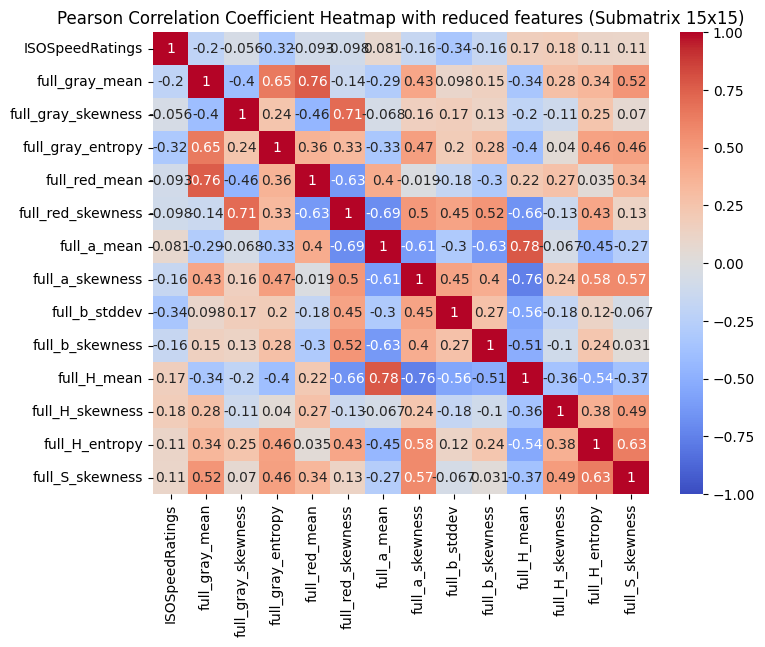

In [30]:
# Import df_onehot_dropped from a pickle file
import pandas as pd
import seaborn as sns

df_numeric_dropped = pd.read_pickle('df_numeric_dropped.pkl')
correlation_matrix_numeric = pd.read_pickle('correlation_matrix_numeric.pkl')

# Plot the heatmap of the remaining features
FEATURES_COLUMNS = [col for col in df_numeric_dropped.columns if col not in LABEL_COLUMNS]
print(f"{len(FEATURES_COLUMNS) = }")
SUBMATRIX_SIZE = 15
correlation_matrix_numeric_dropped = correlation_matrix_numeric[FEATURES_COLUMNS].loc[FEATURES_COLUMNS]

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_numeric_dropped.iloc[:SUBMATRIX_SIZE, :SUBMATRIX_SIZE], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Pearson Correlation Coefficient Heatmap with reduced features (Submatrix {SUBMATRIX_SIZE}x{SUBMATRIX_SIZE})')
plt.show()

We notice that with a treshold of 0.8, we drop 147 numeric features and we are left with only 14 features. We keep going on.

We also notice that with our previous method, using one hot encoding of categorical features, we dropped in total 148 features, that means that 147 were numeric. Probably there was an error with approach? Or maybe categorical features have much less correlation with each other. - CHECK - find an answer

We calculate chi-squared correlation with the each feature with the label `class_target`, we drop the columns with a correlation below a threshold

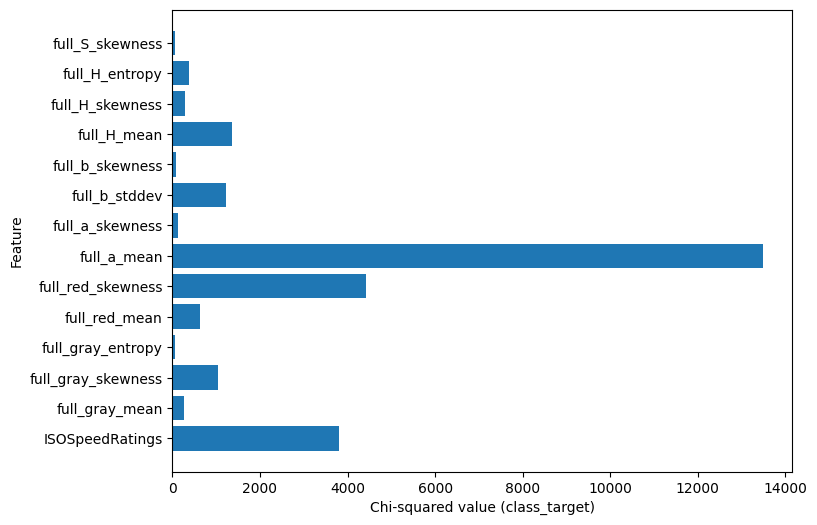

Mean of chi-squared values: 1947.5067018015345
Standard deviation of chi-squared values: 3463.9788713925836
Threshold for chi-squared values: 215.5172661052427
FEATURES_COLUMNS = ['ISOSpeedRatings', 'full_gray_mean', 'full_gray_skewness', 'full_gray_entropy', 'full_red_mean', 'full_red_skewness', 'full_a_mean', 'full_a_skewness', 'full_b_stddev', 'full_b_skewness', 'full_H_mean', 'full_H_skewness', 'full_H_entropy', 'full_S_skewness']
chi2_values = [ 3796.87198234   270.7371623   1045.75692838    66.79721309
   641.02645681  4420.7805857  13486.41456769   125.99226042
  1234.08433349    73.68515238  1371.64728261   298.29224567
   379.96472713    53.04292721]
First 10 features sorted by ascending chi-squared value:
	('full_a_mean', 13486.414567685228)
	('full_red_skewness', 4420.7805856985815)
	('ISOSpeedRatings', 3796.871982344184)
	('full_H_mean', 1371.64728260557)
	('full_b_stddev', 1234.084333492684)
	('full_gray_skewness', 1045.7569283815214)
	('full_red_mean', 641.0264568128798)


In [48]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

df_numeric_dropped = pd.read_pickle('df_numeric_dropped.pkl')

# Convert categorical target to numeric values
le = LabelEncoder()
y_class_target = le.fit_transform(df_numeric_dropped["class_target"])

# Select categorical features for chi-squared test
FEATURES_COLUMNS = [col for col in df_numeric_dropped.columns if col not in LABEL_COLUMNS]

# # Apply non-negative transformation (MinMaxScaler) to the input data because chi-squared test requires non-negative values
scaler = MinMaxScaler()
X_features = scaler.fit_transform(df_numeric_dropped[FEATURES_COLUMNS])

# Chi-squared test
chi2_values, p_values = chi2(X_features, y_class_target)

# Create a plot for the chi-squared values
NUMBER_OF_FEATURES_TO_PLOT = 15

plt.figure(figsize=(8, 6))
plt.barh(FEATURES_COLUMNS[:NUMBER_OF_FEATURES_TO_PLOT], chi2_values[:NUMBER_OF_FEATURES_TO_PLOT])
plt.xlabel('Chi-squared value (class_target)')
plt.ylabel('Feature')
le = LabelEncoder()
y = le.fit_transform(df_numeric_dropped["class_target"])
plt.show()

# Calculate the threshold for chi-squared values making mean plus k standard deviations
print(f"Mean of chi-squared values: {chi2_values.mean()}")
print(f"Standard deviation of chi-squared values: {chi2_values.std()}")

k = - 1/2
threshold = chi2_values.mean() + k * chi2_values.std()

print(f"Threshold for chi-squared values: {threshold}")

# Sort features by chi-squared value using sorted
print(f"FEATURES_COLUMNS = {FEATURES_COLUMNS}")
print(f"chi2_values = {chi2_values}")

feature_columns_with_chi_squared_value = sorted(zip(FEATURES_COLUMNS, chi2_values), key=lambda x: x[1], reverse=True)
# Update FEATURES_COLUMNS and chi2_values
FEATURES_COLUMNS, chi2_values = zip(*feature_columns_with_chi_squared_value)

# First 10 features
print(f"First 10 features sorted by ascending chi-squared value:")
for i in range(10):
    print(f"\t{feature_columns_with_chi_squared_value[i]}")

# Last 10 features
print(f"Last 10 features sorted by ascending chi-squared value:")
for i in range(10):
    print(f"\t{feature_columns_with_chi_squared_value[-i - 1]}")

# Drop columns with chi-squared value below the threshold
to_drop = [col for col, chi2_val in zip(FEATURES_COLUMNS, chi2_values) if chi2_val < threshold]
print(f"Columns with chi-squared value below {threshold}: {to_drop}")
df_numeric_dropped_chi2 = df_numeric_dropped.drop(columns=to_drop)
print(f"Dropped {len(to_drop)} columns with chi-squared value below {threshold}: {to_drop}")

# Save df_numeric_dropped_chi2 to a pickle file
df_numeric_dropped_chi2.to_pickle('df_numeric_dropped_chi2.pkl')

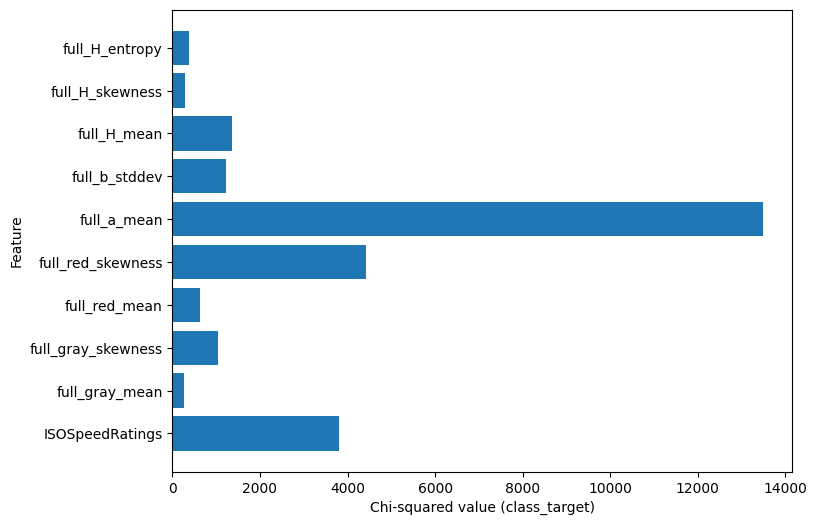

FEATURES_COLUMNS: ['full_a_mean', 'full_red_skewness', 'ISOSpeedRatings', 'full_H_mean', 'full_b_stddev', 'full_gray_skewness', 'full_red_mean', 'full_H_entropy', 'full_H_skewness', 'full_gray_mean']
First 10 features sorted by ascending chi-squared value:
	full_a_mean: 3796.871982344184
	full_red_skewness: 270.7371623011593
	ISOSpeedRatings: 1045.7569283815214
	full_H_mean: 641.0264568128798
	full_b_stddev: 4420.7805856985815
	full_gray_skewness: 13486.414567685228
	full_red_mean: 1234.084333492684
	full_H_entropy: 1371.64728260557
	full_H_skewness: 298.292245671273
	full_gray_mean: 379.9647271271967
Last 10 features sorted by ascending chi-squared value:
	full_gray_mean: 379.9647271271967
	full_H_skewness: 298.292245671273
	full_H_entropy: 1371.64728260557
	full_red_mean: 1234.084333492684
	full_gray_skewness: 13486.414567685228
	full_b_stddev: 4420.7805856985815
	full_H_mean: 641.0264568128798
	ISOSpeedRatings: 1045.7569283815214
	full_red_skewness: 270.7371623011593
	full_a_mean: 3

In [49]:
# Import df_numeric_dropped_chi2 from a pickle file
df_numeric_dropped_chi2 = pd.read_pickle('df_numeric_dropped_chi2.pkl')

# Create a new plot for the Chi-squared values
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

FEATURES_COLUMNS = [col for col in df_numeric_dropped_chi2.columns if col not in LABEL_COLUMNS]
scaler = MinMaxScaler()
le = LabelEncoder()
X_features = scaler.fit_transform(df_numeric_dropped_chi2[FEATURES_COLUMNS])
y_class_target = le.fit_transform(df_numeric_dropped_chi2["class_target"])
chi2_values, _ = chi2(X_features, y_class_target)
plt.figure(figsize=(8, 6))
NUMBER_OF_FEATURES_TO_PLOT = 15
plt.barh(FEATURES_COLUMNS[:NUMBER_OF_FEATURES_TO_PLOT], chi2_values[:NUMBER_OF_FEATURES_TO_PLOT])
plt.xlabel('Chi-squared value (class_target)')
plt.ylabel('Feature')
plt.show()

# Sort features by chi-squared value using sorted
feature_columns_with_chi_squared_value = sorted(zip(FEATURES_COLUMNS, chi2_values), key=lambda x: x[1], reverse=True)
FEATURES_COLUMNS = [col for col, chi2_val in feature_columns_with_chi_squared_value]
print(f"FEATURES_COLUMNS: {FEATURES_COLUMNS}")

# Print the first 10 features sorted by ascending chi-squared value
print(f"First 10 features sorted by ascending chi-squared value:")
for i in range(10):
    print(f"\t{FEATURES_COLUMNS[i]}: {chi2_values[i]}")

# Print the last 10 features sorted by ascending chi-squared value
print(f"Last 10 features sorted by ascending chi-squared value:")
for i in range(10):
    print(f"\t{FEATURES_COLUMNS[-i - 1]}: {chi2_values[-i - 1]}")

# TODO - CHECK: understand why since value_target is continuous, it is not possible to apply chi-squared
# # Do the same for value_target (numeric feature)
# # Apply non-negative transformation to the input data
# scaler = MinMaxScaler()
# X = scaler.fit_transform(df_numeric_dropped_chi2[FEATURES_COLUMNS])
# y = df["value_target"]

# # Chi-squared test
# chi2_values, p_values = chi2(X, y)

# # Create a plot for the chi-squared values
# plt.figure(figsize=(8, 6))
# plt.barh(FEATURES_COLUMNS, chi2_values)
# plt.xlabel('Chi-squared value (value_target)')
# plt.ylabel('Feature')
# plt.show()

# # Drop columns with chi-squared value below a threshold
# threshold = 0.1
# to_drop = [col for col, chi2_val in zip(FEATURES_COLUMNS, chi2_values) if chi2_val < threshold]
# df_numeric_dropped_chi2 = df_numeric_dropped_chi2.drop(columns=to_drop)

# # Create a new plot for the Chi-squared values
# FEATURES_COLUMNS = [col for col in df_numeric_dropped_chi2.columns if col not in LABEL_COLUMNS]
# chi2_values, _ = chi2(X, y)
# plt.figure(figsize=(8, 6))
# plt.barh(FEATURES_COLUMNS, chi2_values)
# plt.xlabel('Chi-squared value (value_target)')
# plt.ylabel('Feature')
# plt.show()

We do feature importance, just to compare

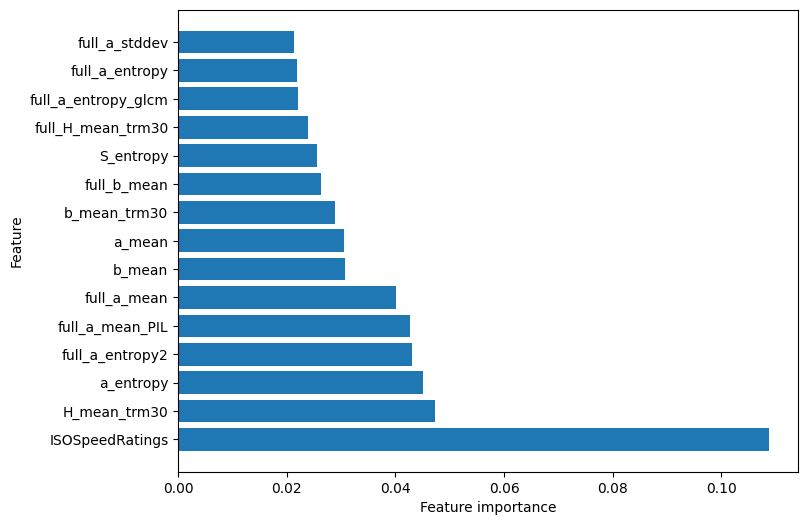

1. ISOSpeedRatings: 0.10869461360850348
2. H_mean_trm30: 0.047192864124490794
3. a_entropy: 0.04504133262303223
4. full_a_entropy2: 0.04297915094598413
5. full_a_mean_PIL: 0.042671146114982614
6. full_a_mean: 0.040131318945541596
7. b_mean: 0.030732465976140745
8. a_mean: 0.030472737460985784
9. b_mean_trm30: 0.028936878313052482
10. full_b_mean: 0.02621164501134301
11. S_entropy: 0.02547123285226464
12. full_H_mean_trm30: 0.023980394315422766
13. full_a_entropy_glcm: 0.02206931617597061
14. full_a_entropy: 0.021956271173831896
15. full_a_stddev: 0.021305714662820916
16. full_b_mean_PIL: 0.02107998893499414
17. a_stddev: 0.020610750219337243
18. S_entropy_glcm: 0.02029193339782804
19. full_S_entropy2: 0.01987223240133461
20. full_S_entropy: 0.018878755667126813
21. full_b_stddev: 0.01679582295264597
22. V_mean: 0.01629268056639129
23. full_gray_mean_trm30: 0.01520286940105979
24. full_V_mean: 0.015197351894072161
25. full_blue_stddev: 0.015110991901454335
26. full_gray_mean: 0.01466979

In [55]:
# Do feature selection using Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
FEATURES_COLUMNS = [col for col in df_numeric.columns if col not in LABEL_COLUMNS]
X = df_numeric[FEATURES_COLUMNS]
y = le.fit_transform(df_numeric["class_target"])

# Train a random forest classifier
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Sort features by importance using sorted in descending order
feature_columns_with_importance = sorted(zip(FEATURES_COLUMNS, feature_importances), key=lambda x: x[1], reverse=True)
FEATURES_COLUMNS, feature_importances = zip(*feature_columns_with_importance)

# Create a plot for the feature importances
NUMBER_OF_FEATURES_TO_PLOT = 15
plt.figure(figsize=(8, 6))
plt.barh(FEATURES_COLUMNS[:NUMBER_OF_FEATURES_TO_PLOT], feature_importances[:NUMBER_OF_FEATURES_TO_PLOT])
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

# Sort features by importance using sorted and print them
feature_columns_with_importance = sorted(zip(FEATURES_COLUMNS, feature_importances), key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(feature_columns_with_importance):
    print(f"{i + 1}. {feature}: {importance}")

# Dimentionality reduction

We won't perform dimensionality reduction, because we have very few features

We perform a PCA. We tried many different number of components and we tried with different number of features selected with previous methods.

In [20]:
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Set the number of components
scaler = MinMaxScaler()
FEATURES_COLUMNS = [col for col in df_onehot_dropped_chi2.columns if col not in LABEL_COLUMNS]
X_features = scaler.fit_transform(df_onehot_dropped_chi2[FEATURES_COLUMNS])
n_components = min(200, len(FEATURES_COLUMNS))

# Create an instance of PCA with the desired number of components
print(f"Doing PCA with {n_components} components")
pca = PCA(n_components=n_components)

# Fit the PCA model to your data
pca.fit(X_features)

# Transform the data to the principal components
X_pca = pca.transform(X_features)

pickle.dump(X_pca, open('X_pca.pkl', 'wb'))

Doing PCA with 200 components


Explained variance ratio: [0.10443914 0.06270869 0.02859874 0.01948867 0.01861078 0.01258539
 0.01212338 0.01199419 0.01188492 0.01158472 0.01127113 0.01106526
 0.01090896 0.01086499 0.01065743 0.01049997 0.01048264 0.01030682
 0.01017859 0.01011363 0.01004414 0.00996989 0.00979248 0.00975223
 0.00974745 0.00969187 0.00960803 0.00936484 0.00916226 0.00907832
 0.0089801  0.00880711 0.00859664 0.00843225 0.00829    0.00825822
 0.00825105 0.0082498  0.00824809 0.0080131  0.00796055 0.00768343
 0.00752561 0.00750628 0.00750041 0.0073124  0.0071257  0.00703839
 0.00682097 0.00679775 0.00675789 0.00670158 0.00623829 0.00614957
 0.0061243  0.00603275 0.00547332 0.0031793  0.00204126 0.0014917
 0.00136046 0.00101891 0.00078539 0.00076091 0.00075614 0.00074977
 0.00074977 0.00074977 0.00074977 0.00074977 0.00074977 0.00074977
 0.00074977 0.00074977 0.00074977 0.00074977 0.00074977 0.00074977
 0.00074977 0.00074977 0.00074977 0.00074977 0.00074977 0.00074977
 0.00074977 0.00074977 0.00074977 0.0

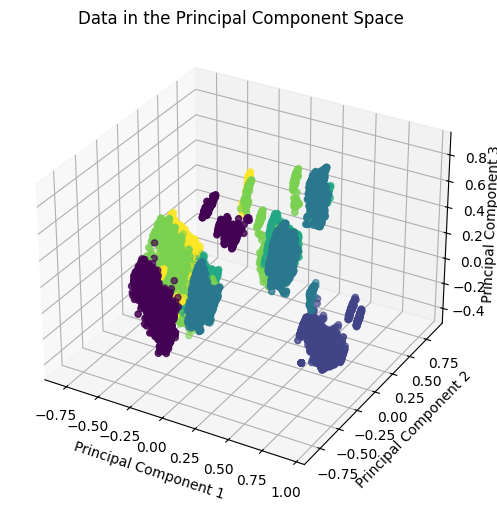

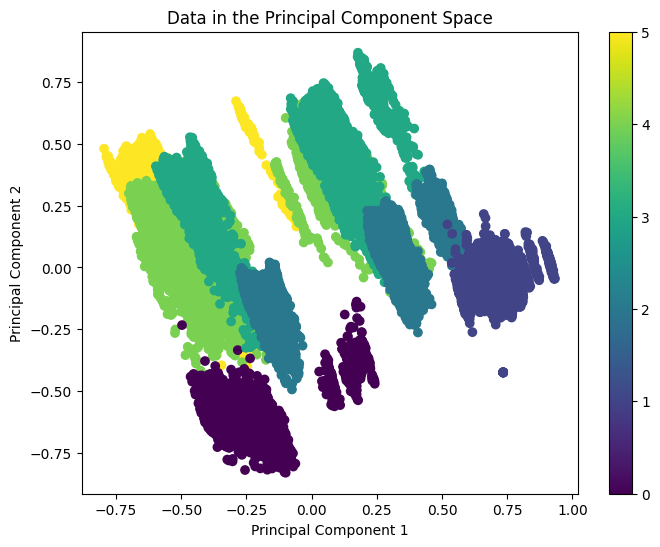

In [21]:
# Import X_pca from a pickle file
import pickle
X_pca = pickle.load(open('X_pca.pkl', 'rb'))
y = le.fit_transform(df_onehot["class_target"])

# Print the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance_ratio}")
print(f"Total explained variance ratio: {sum(explained_variance_ratio)}")

# # Plot the data in the principal component space
# plt.scatter(X_pca[:, 0], X_pca[:, 1])
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('PCA')
# plt.show()

# Plot the data in the principal component space
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Data in the Principal Component Space')
ax.zaxis.labelpad=-1        # Improve visibility of the z-axis label
plt.show()


# Plot the data in the principal component space
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data in the Principal Component Space')
plt.colorbar()


We perform a t-SNE on the PCA result. We apply PCA first because t-SNE is more computationally expensive.

Doing t-SNE with 2 components


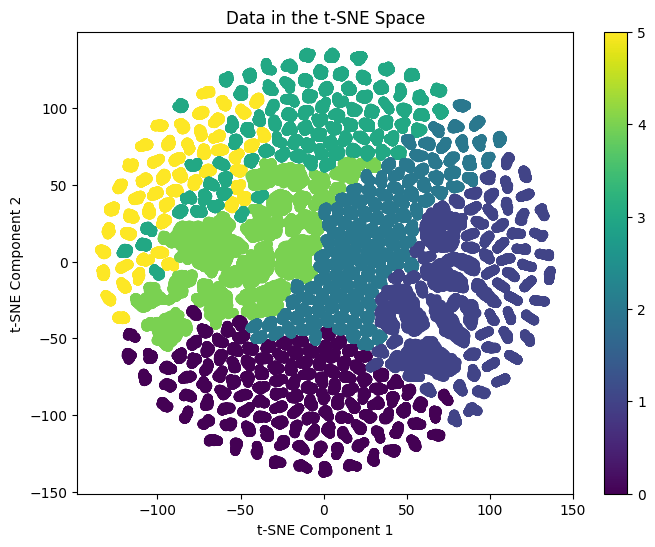

In [22]:
# Apply t-SNE
from sklearn.manifold import TSNE

# Set the number of components
n_components = 2

# Create an instance of TSNE with the desired number of components
print(f"Doing t-SNE with {n_components} components")
tsne = TSNE(n_components=n_components)

# Fit the t-SNE model to your data
X_tsne = tsne.fit_transform(X_pca)

# Plot the data in the t-SNE space
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Data in the t-SNE Space')
plt.colorbar()
plt.show()

# Save X_tsne to a pickle file
import pickle

pickle.dump(X_tsne, open('X_tsne.pkl', 'wb'))

c:\Users\Fral0\Desktop\Workbench\progetto-piccialli\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Doing UMAP with 2 components


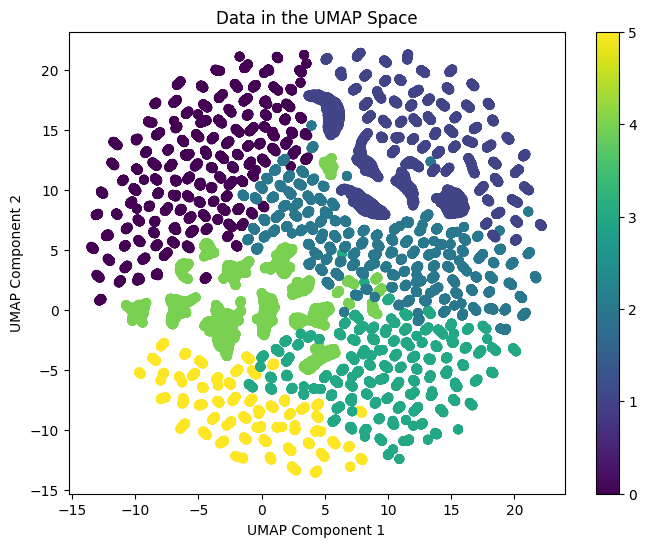

In [23]:
# Apply UMAP
import umap

# Set the number of components
n_components = 2

# Create an instance of UMAP with the desired number of components
print(f"Doing UMAP with {n_components} components")

# Fit the UMAP model to your data
umap_model = umap.UMAP(n_components=n_components)
X_umap = umap_model.fit_transform(X_pca)

# Plot the data in the UMAP space
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('Data in the UMAP Space')
plt.colorbar()
plt.show()

# Save X_umap to a pickle file
import pickle

pickle.dump(X_umap, open('X_umap.pkl', 'wb'))

# Training - Classification

Let's define the train and test set.

In [24]:
import pickle

# Import Xs from a pickle files
X_pca = pickle.load(open('X_pca.pkl', 'rb'))
X_tsne = pickle.load(open('X_tsne.pkl', 'rb'))
X_umap = pickle.load(open('X_umap.pkl', 'rb'))

In [25]:
# Split the data into training and testing sets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set the dataset
le = LabelEncoder()
X = X_umap
y = le.fit_transform(df_onehot_dropped_chi2["class_target"])

# Set the test size
test_size = 0.2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) # random_state set for reproducibility

# Print the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Print unique values of y_train and y_test
print()
print(f"Unique values of y_train: {np.unique(y_train)}")

# Print example of train and test data
print()
print("Example of train data:")
print(f"X_train[0]: {X_train[0]}")
print(f"y_train[0]: {y_train[0]}")

print()
print("Example of test data:")
print(f"X_test[0]: {X_test[0]}")
print(f"y_test[0]: {y_test[0]}")

# Save to pickle files
pickle.dump(X, open('X_classification.pkl', 'wb'))
pickle.dump(X_train, open('X_train_classification.pkl', 'wb'))
pickle.dump(X_test, open('X_test_classification.pkl', 'wb'))
pickle.dump(y, open('y_classification.pkl', 'wb'))
pickle.dump(y_train, open('y_train_classification.pkl', 'wb'))
pickle.dump(y_test, open('y_test_classification.pkl', 'wb'))


X_train shape: (49612, 2)
X_test shape: (12404, 2)
y_train shape: (49612,)
y_test shape: (12404,)

Unique values of y_train: [0 1 2 3 4 5]

Example of train data:
X_train[0]: [-11.283825    2.3125212]
y_train[0]: 0

Example of test data:
X_test[0]: [15.193762 13.560269]
y_test[0]: 1


We import the training and test data

In [26]:
# Import the training and test data from pickle files
import pickle

X = pickle.load(open('X_classification.pkl', 'rb'))
X_train = pickle.load(open('X_train_classification.pkl', 'rb'))
X_test = pickle.load(open('X_test_classification.pkl', 'rb'))
y = pickle.load(open('y_classification.pkl', 'rb'))
y_train = pickle.load(open('y_train_classification.pkl', 'rb'))
y_test = pickle.load(open('y_test_classification.pkl', 'rb'))

We apply Naive Bayes, that has the model performance that we want to beat.

Accuracy: 0.8420670751370526
Scatter plot of the test data:


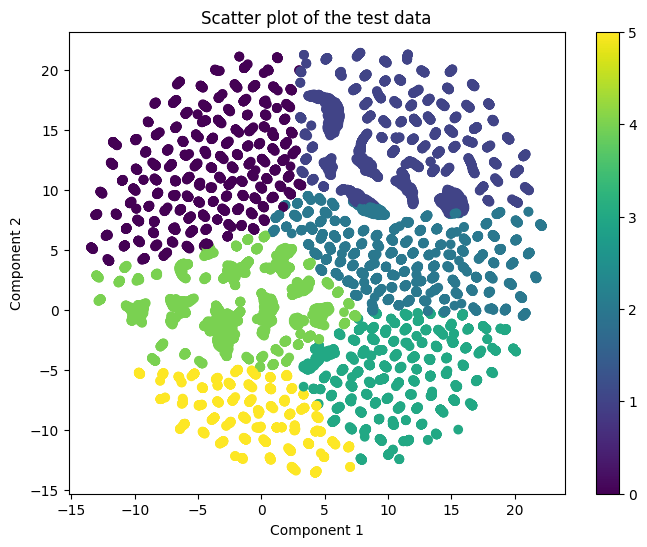

Confusion matrix:


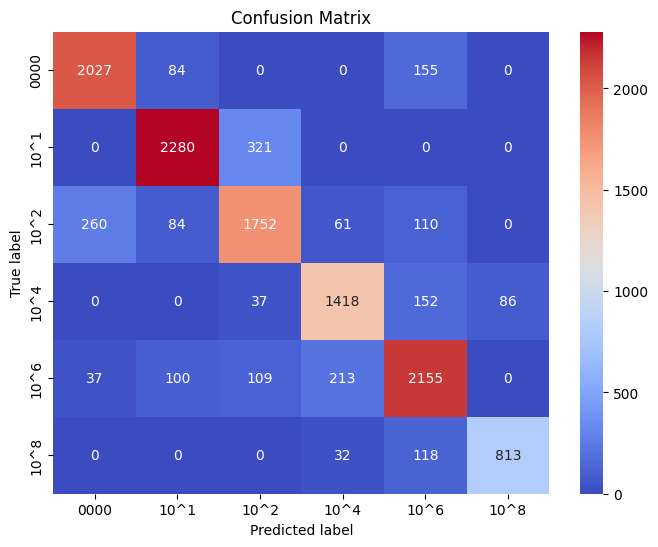

Classification Report:
              precision    recall  f1-score   support

        0000       0.87      0.89      0.88      2266
        10^1       0.89      0.88      0.89      2601
        10^2       0.79      0.77      0.78      2267
        10^4       0.82      0.84      0.83      1693
        10^6       0.80      0.82      0.81      2614
        10^8       0.90      0.84      0.87       963

    accuracy                           0.84     12404
   macro avg       0.85      0.84      0.84     12404
weighted avg       0.84      0.84      0.84     12404



In [27]:
# Apply Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Create an instance of the model
nb = GaussianNB()

# Fit the model to the training data
nb.fit(X_train, y_train)

# Predict the classes of the test data
y_pred = nb.predict(X_test)

# Print the full classification report
print_full_classification_report(y_test, y_pred, X_test=X_test, target_names=CLASSES_SHORT)

We apply K-means

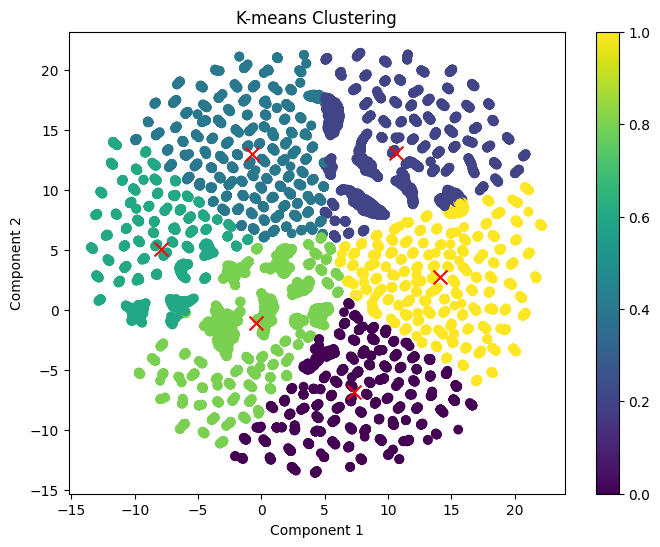

Accuracy: 0.359642050951306
Silhouette score: 0.31515341997146606
Inertia: 1378812.875
Accuracy: 0.359642050951306
Confusion matrix:


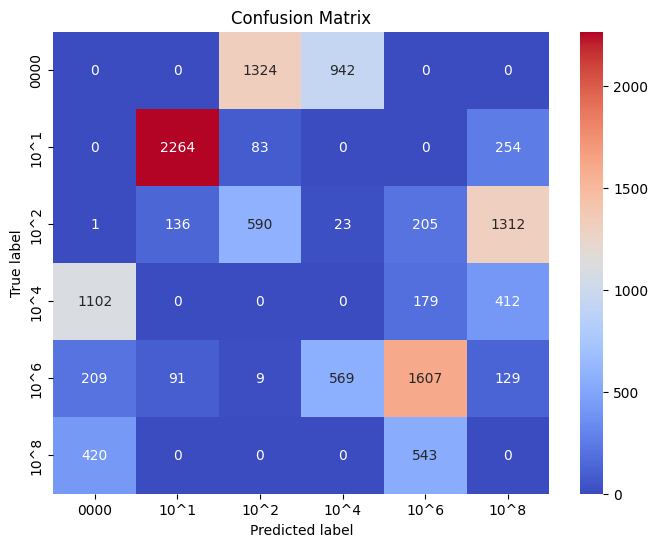

Classification Report:
              precision    recall  f1-score   support

        0000       0.00      0.00      0.00      2266
        10^1       0.91      0.87      0.89      2601
        10^2       0.29      0.26      0.28      2267
        10^4       0.00      0.00      0.00      1693
        10^6       0.63      0.61      0.62      2614
        10^8       0.00      0.00      0.00       963

    accuracy                           0.36     12404
   macro avg       0.31      0.29      0.30     12404
weighted avg       0.38      0.36      0.37     12404



In [28]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score

np.random.seed(5)

# Set the number of clusters
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)

# Fit the K-means model to the data
kmeans.fit(X_train)
y_pred = kmeans.predict(X_test)

# Get the cluster centers
centroids = kmeans.cluster_centers_

# Plot the data and the cluster centers
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('K-means Clustering')
plt.colorbar()
plt.show()

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate the silhouette score
silhouette = silhouette_score(X_test, y_pred)
print(f"Silhouette score: {silhouette}")

# Calculate the intertia
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

# Print the full classification report
print_full_classification_report(y_test, y_pred, target_names=CLASSES_SHORT)

We apply K-medoids

In [29]:
# import numpy as np
# from sklearn_extra.cluster import KMedoids
# from sklearn.metrics import accuracy_score

# np.random.seed(5)

# # Set the number of clusters
# n_clusters = 6
# kmedoids = KMedoids(n_clusters=n_clusters)

# # Fit the K-means model to the data
# kmedoids.fit(X_train)
# y_pred = kmedoids.predict(X_test)

# # Get the cluster centers
# medoids = kmedoids.cluster_centers_

# # Plot the data and the cluster centers
# plt.figure(figsize=(8, 6))
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis')
# plt.scatter(medoids[:, 0], medoids[:, 1], c='red', marker='x', s=100)
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.title('K-means Clustering')
# plt.colorbar()
# plt.show()

# # Calculate the accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# # Calculate the silhouette score
# silhouette = silhouette_score(X_test, y_pred)
# print(f"Silhouette score: {silhouette}")

# # Calculate the intertia
# inertia = kmedoids.inertia_
# print(f"Inertia: {inertia}")

We apply SVM

Accuracy: 0.928087713640761
Scatter plot of the test data:


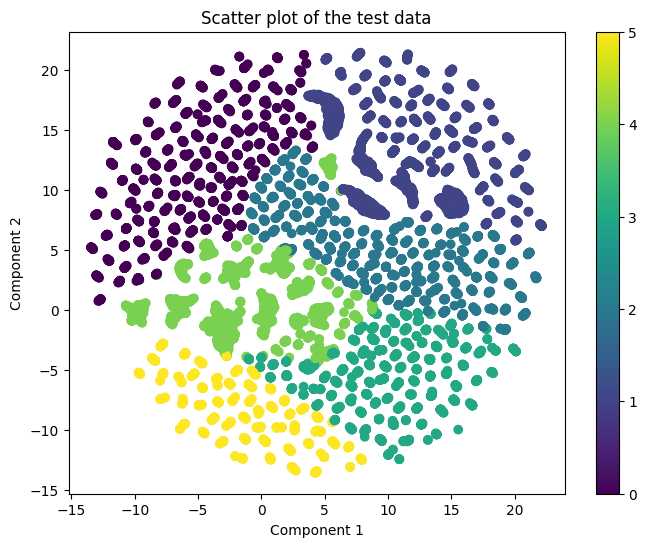

Confusion matrix:


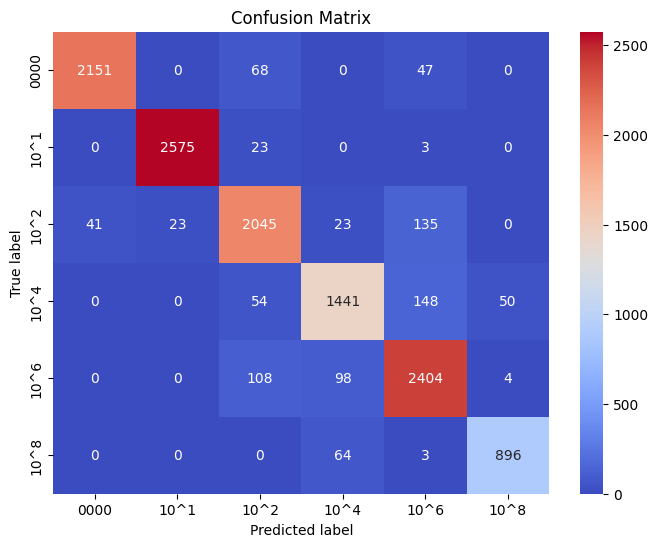

Classification Report:
              precision    recall  f1-score   support

        0000       0.98      0.95      0.97      2266
        10^1       0.99      0.99      0.99      2601
        10^2       0.89      0.90      0.90      2267
        10^4       0.89      0.85      0.87      1693
        10^6       0.88      0.92      0.90      2614
        10^8       0.94      0.93      0.94       963

    accuracy                           0.93     12404
   macro avg       0.93      0.92      0.93     12404
weighted avg       0.93      0.93      0.93     12404



In [30]:
# Apply SVM
from sklearn.svm import SVC

# Set the SVM model
svm = SVC()

# Fit the SVM model to the data
svm.fit(X_train, y_train)

# Predict the labels
y_pred = svm.predict(X_test)

# Print full classification report
print_full_classification_report(y_test, y_pred, X_test, target_names=CLASSES_SHORT)

We apply random forest

Accuracy: 0.9998387616897775
Scatter plot of the test data:


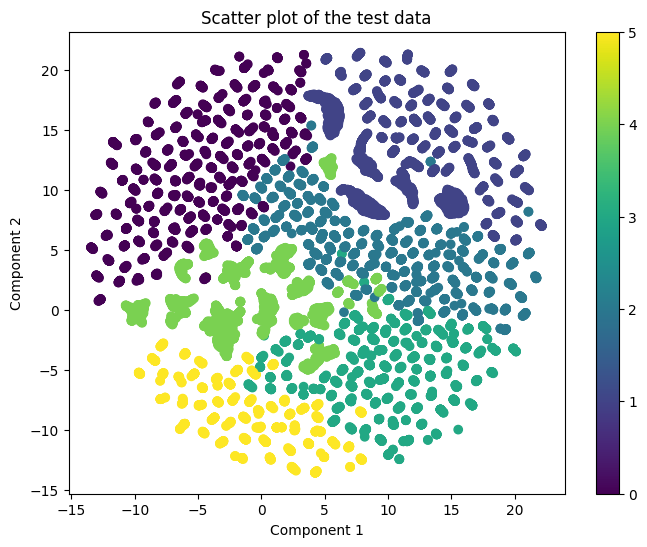

Confusion matrix:


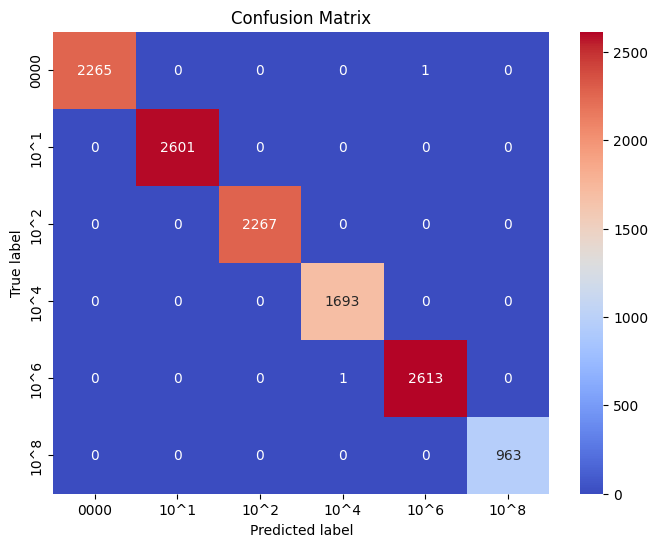

Classification Report:
              precision    recall  f1-score   support

        0000       1.00      1.00      1.00      2266
        10^1       1.00      1.00      1.00      2601
        10^2       1.00      1.00      1.00      2267
        10^4       1.00      1.00      1.00      1693
        10^6       1.00      1.00      1.00      2614
        10^8       1.00      1.00      1.00       963

    accuracy                           1.00     12404
   macro avg       1.00      1.00      1.00     12404
weighted avg       1.00      1.00      1.00     12404



In [31]:
# Train a classifier
from sklearn.ensemble import RandomForestClassifier

# Set the number of estimators
n_estimators = 10

# Create an instance of the classifier
clf = RandomForestClassifier(n_estimators=n_estimators)

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels
y_pred = clf.predict(X_test)

# Print full classification report
print_full_classification_report(y_test, y_pred, X_test, target_names=CLASSES_SHORT)

We apply XGBoost

Accuracy: 0.9916962270235408
Scatter plot of the test data:


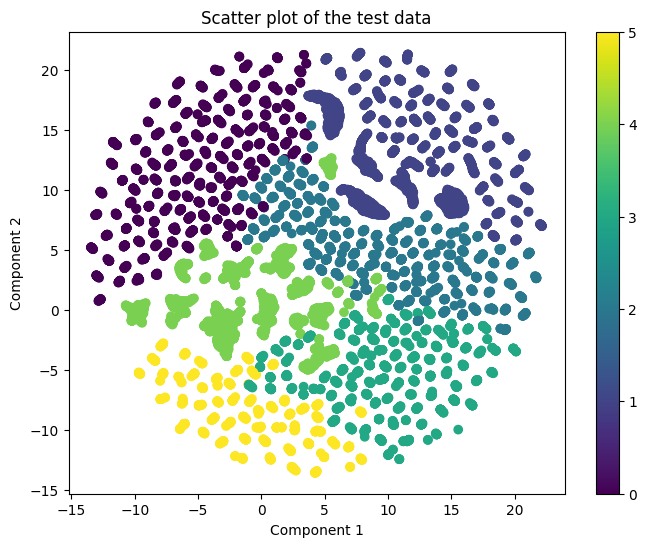

Confusion matrix:


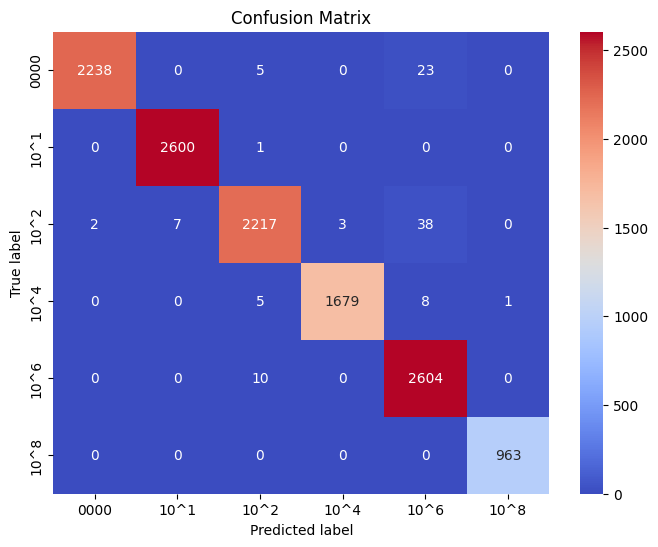

Classification Report:
              precision    recall  f1-score   support

        0000       1.00      0.99      0.99      2266
        10^1       1.00      1.00      1.00      2601
        10^2       0.99      0.98      0.98      2267
        10^4       1.00      0.99      0.99      1693
        10^6       0.97      1.00      0.99      2614
        10^8       1.00      1.00      1.00       963

    accuracy                           0.99     12404
   macro avg       0.99      0.99      0.99     12404
weighted avg       0.99      0.99      0.99     12404



In [32]:
# Apply XGBoost
import xgboost as xgb
from sklearn.metrics import silhouette_score

# Set the number of estimators
n_estimators = 10

# Create an instance of the classifier
clf = xgb.XGBClassifier(n_estimators=n_estimators)

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels
y_pred = clf.predict(X_test)

# Print full classification report
print_full_classification_report(y_test, y_pred, X_test, target_names=CLASSES_SHORT)

We apply hierarchical clustering

In [33]:
# # Apply hierarchical clustering
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import accuracy_score, silhouette_score

# n_clusters = 6

# classifier = AgglomerativeClustering(n_clusters=n_clusters)
# classifier.fit(X_train)
# y_pred = classifier.predict(X_test)

# # Calculate the accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# # Calculate the silhouette score
# silhouette = silhouette_score(X_test, y_pred)
# print(f"Silhouette score: {silhouette}")

# # Plot the data with predicted clusters
# plt.figure(figsize=(8, 6))
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.title('Agglomerative Clustering')
# plt.colorbar()
# plt.show()

We apply KNN

Accuracy: 1.0
Scatter plot of the test data:


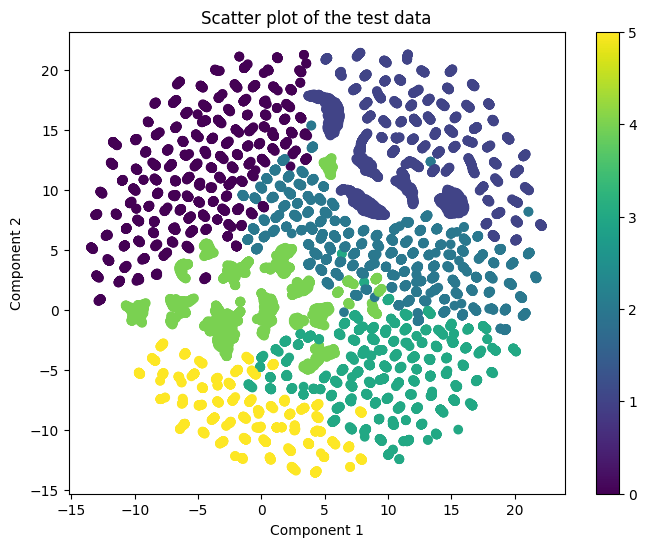

Confusion matrix:


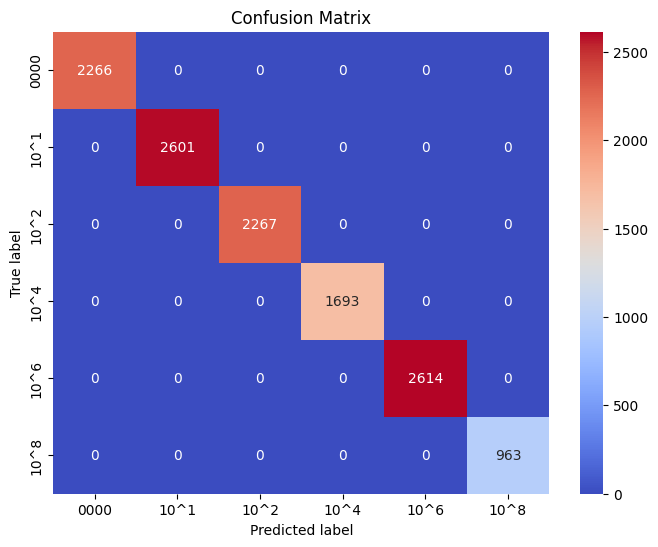

Classification Report:
              precision    recall  f1-score   support

        0000       1.00      1.00      1.00      2266
        10^1       1.00      1.00      1.00      2601
        10^2       1.00      1.00      1.00      2267
        10^4       1.00      1.00      1.00      1693
        10^6       1.00      1.00      1.00      2614
        10^8       1.00      1.00      1.00       963

    accuracy                           1.00     12404
   macro avg       1.00      1.00      1.00     12404
weighted avg       1.00      1.00      1.00     12404



In [34]:
# Apply KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Set the number of neighbors
n_neighbors = 7

# Create an instance of the classifier
clf = KNeighborsClassifier(n_neighbors=n_neighbors)

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels
y_pred = clf.predict(X_test)

# Print the full classification report
print_full_classification_report(y_test, y_pred, X_test, target_names=CLASSES_SHORT)

### Deep learning

In [2]:
%pip install tensorflow
%pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from numpy.typing import NDArray
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle

# Import the data from pickle files
df_onehot_dropped_chi2 = pd.read_pickle('df_onehot_dropped_chi2.pkl')
X_umap = pickle.load(open('X_umap.pkl', 'rb'))

# Set train, test and validation data
X: NDArray[np.float64] = X_umap
y = pd.get_dummies(df_onehot_dropped_chi2["class_target"])
y = y.to_numpy(dtype=np.int32)
# y = y.to_numpy(dtype=np.float64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

print(f"X_train shape: {X_train.shape}")
print(f"X train example: {X_train[0]}\n")

print(f"X_valid shape: {X_valid.shape}")
print(f"X valid example: {X_valid[0]}\n")

print(f"X_test shape: {X_test.shape}")
print(f"X test example: {X_test[0]}\n")

print(f"y_train shape: {y_train.shape}")
print(f"y_train example: {y_train[0]}\n")

print(f"y_valid shape: {y_valid.shape}")
print(f"y_valid example: {y_valid[0]}\n")

print(f"y_test shape: {y_test.shape}")
print(f"y_test example: {y_test[0]}\n")

X_train shape: (39689, 2)
X train example: [-6.5445604  -0.03289979]

X_valid shape: (9923, 2)
X valid example: [-12.6889515   9.847068 ]

X_test shape: (12404, 2)
X test example: [15.193762 13.560269]

y_train shape: (39689, 6)
y_train example: [0 0 0 0 1 0]

y_valid shape: (9923, 6)
y_valid example: [1 0 0 0 0 0]

y_test shape: (12404, 6)
y_test example: [0 1 0 0 0 0]



c:\Users\Fral0\Desktop\Workbench\progetto-piccialli\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 5)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 6)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

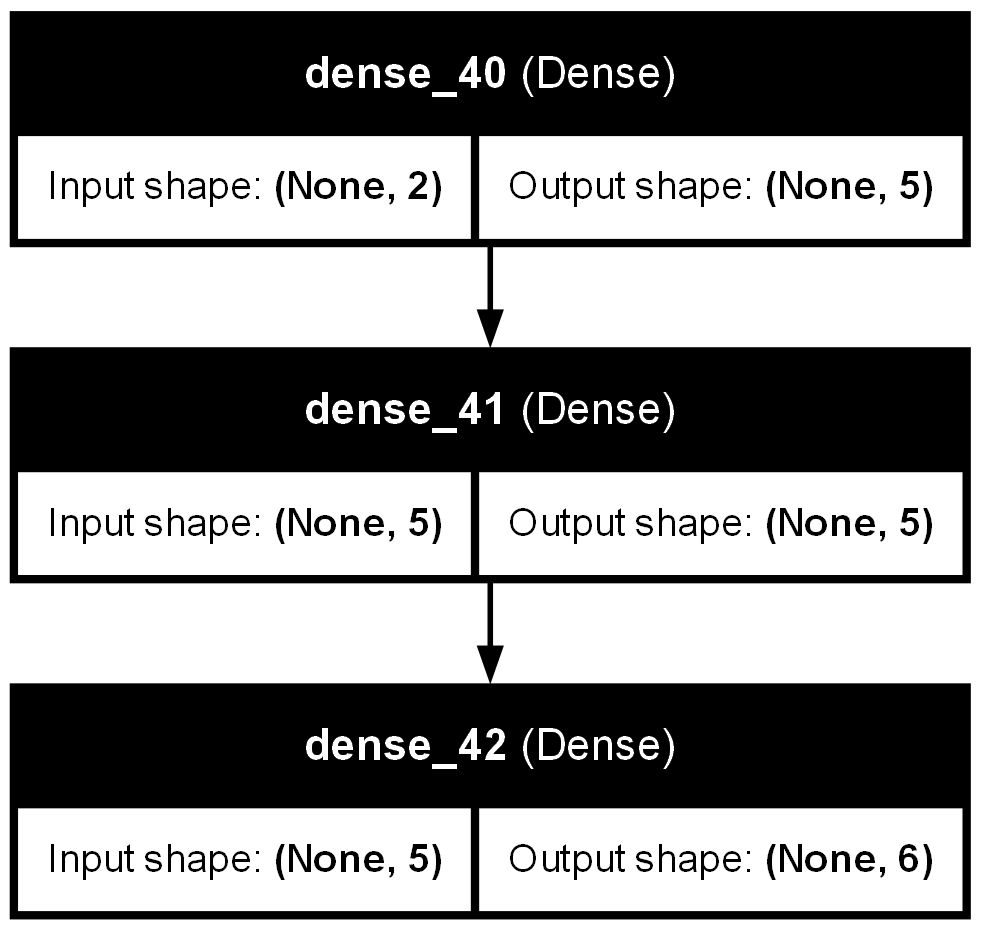

In [10]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

reg = tf.keras.regularizers.l2(0.0001)

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(5, activation='relu', input_shape=(X_train.shape[-1],), kernel_regularizer=reg),
        tf.keras.layers.Dense(5, activation='relu', kernel_regularizer=reg),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ]
)

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

model.summary()


# Plot the model architecture (you need to have Graphviz installed on your machine)
plot_model(model, show_shapes=True, show_layer_names=True)

In [11]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=126, verbose=1)

# Save the model and history to a file
model.save('model.keras')
pickle.dump(history, open('history.pkl', 'wb'))

Epoch 1/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2913 - loss: 1.8810 - mae: 0.2565 - mse: 0.1452 - val_accuracy: 0.4392 - val_loss: 1.1904 - val_mae: 0.2054 - val_mse: 0.0961
Epoch 2/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4590 - loss: 1.1072 - mae: 0.1943 - mse: 0.0911 - val_accuracy: 0.6163 - val_loss: 0.8940 - val_mae: 0.1687 - val_mse: 0.0769
Epoch 3/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6402 - loss: 0.8448 - mae: 0.1616 - mse: 0.0733 - val_accuracy: 0.7007 - val_loss: 0.7427 - val_mae: 0.1480 - val_mse: 0.0663
Epoch 4/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7141 - loss: 0.7163 - mae: 0.1437 - mse: 0.0642 - val_accuracy: 0.7575 - val_loss: 0.6444 - val_mae: 0.1332 - val_mse: 0.0586
Epoch 5/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7513 - loss: 0.6349 - mae: 0.1312 - mse: 0.0578 - val_accuracy: 0.7720 - val_loss: 0.5712 - val_mae: 0.1204 - val_mse: 0.0524
Epoch 6/100
315/315 ━━━━━━━━━━━━━━━

In [12]:
# Import the model and history from a file
import pickle
import tensorflow as tf

model = tf.keras.models.load_model('model.keras')
history = pickle.load(open('history.pkl', 'rb'))

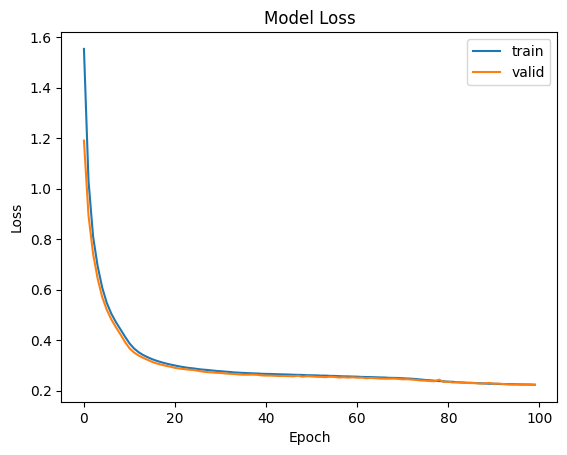

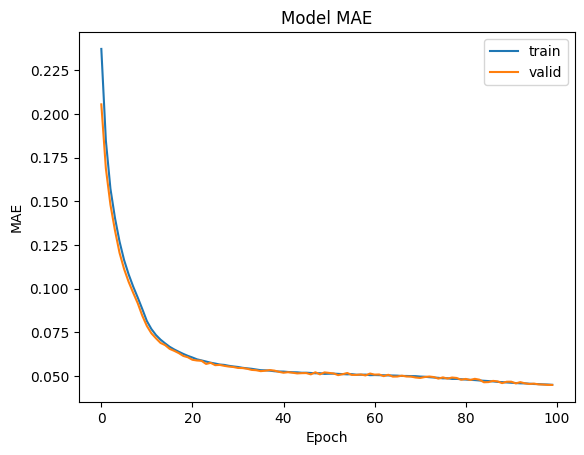

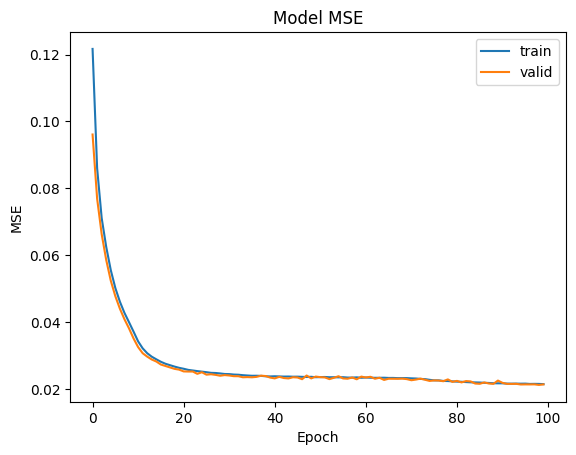

In [15]:
create_training_history_plot(history)

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.9067 - loss: 0.2174 - mae: 0.0434 - mse: 0.0208
Loss: 0.22235991060733795
Accuracy: 0.9055949449539185
Mean Absolute Error: 0.044042181223630905
Mean Squared Error: 0.021206144243478775
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
First 10 predictions: [1 0 2 4 4 5 4 1 5 1]
Accuracy: 0.9055949693647211
Scatter plot of the test data:


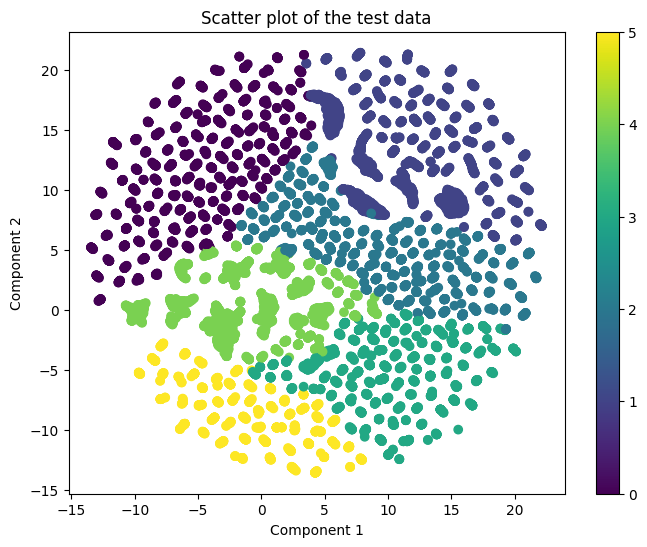

Confusion matrix:


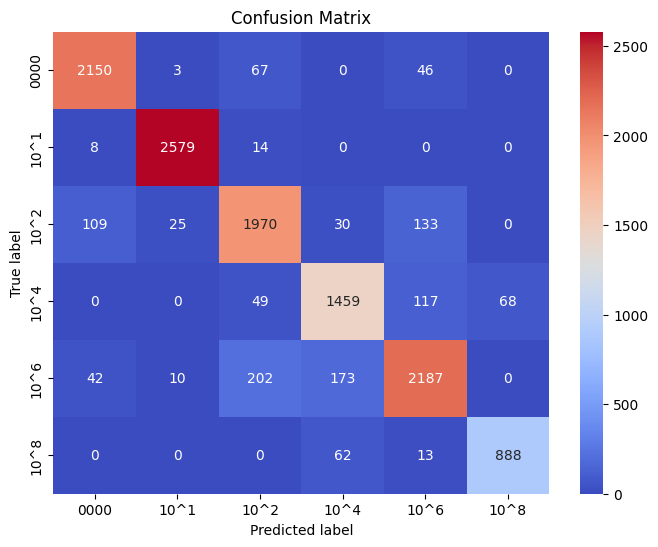

Classification Report:
              precision    recall  f1-score   support

        0000       0.93      0.95      0.94      2266
        10^1       0.99      0.99      0.99      2601
        10^2       0.86      0.87      0.86      2267
        10^4       0.85      0.86      0.85      1693
        10^6       0.88      0.84      0.86      2614
        10^8       0.93      0.92      0.93       963

    accuracy                           0.91     12404
   macro avg       0.90      0.90      0.90     12404
weighted avg       0.91      0.91      0.91     12404



In [20]:
# Evaluate the model
loss, accuracy, mae, mse = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Predict the test data
y_pred = model.predict(X_test)

# Print accuracy
y_pred_1d = np.argmax(y_pred, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

print(f"First 10 predictions: {y_pred_1d[:10]}")

# Print full classification report
print_full_classification_report(y_test_1d, y_pred_1d, X_test, target_names=CLASSES_SHORT)

## Regression

In [46]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set the dataset
X = X_umap
y = df_onehot_dropped_chi2["value_target"].to_numpy()

# Set the test size
test_size = 0.2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

print(f"X_train shape: {X_train.shape}")
print(f"X train example: {X_train[0]}\n")

print(f"X_valid shape: {X_valid.shape}")
print(f"X valid example: {X_valid[0]}\n")

print(f"X_test shape: {X_test.shape}")
print(f"X test example: {X_test[0]}\n")

print(f"y_train shape: {y_train.shape}")
print(f"y_train example: {y_train[0]}\n")

print(f"y_valid shape: {y_valid.shape}")
print(f"y_valid example: {y_valid[0]}\n")

print(f"y_test shape: {y_test.shape}")
print(f"y_test example: {y_test[0]}\n")

# Save to pickle files
pickle.dump(X, open('X_regression.pkl', 'wb'))
pickle.dump(X_train, open('X_train_regression.pkl', 'wb'))
pickle.dump(X_test, open('X_test_regression.pkl', 'wb'))
pickle.dump(y, open('y_regression.pkl', 'wb'))
pickle.dump(y_train, open('y_train_regression.pkl', 'wb'))
pickle.dump(y_test, open('y_test_regression.pkl', 'wb'))

X_train shape: (39689, 2)
X train example: [-6.5445604  -0.03289979]

X_valid shape: (9923, 2)
X valid example: [-12.6889515   9.847068 ]

X_test shape: (12404, 2)
X test example: [15.193762 13.560269]

y_train shape: (39689,)
y_train example: 0.579

y_valid shape: (9923,)
y_valid example: 0.202

y_test shape: (12404,)
y_test example: 0.275



We use the mean of the target value as baseline model

In [47]:
import numpy as np

# Calculate the mean of the target variable in the training set
mean_train = np.mean(y_train)

# Predict the mean for all instances in the test set
y_pred = np.full_like(y_test, mean_train)

print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.1535334156129856
Mean squared error: 0.052199968142568894
Mean relative error: 0.416373844122698


We use Linear Regression

In [48]:
# Do regression using Linear Regression
from sklearn.linear_model import LinearRegression

# Set the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.11117539805798561
Mean squared error: 0.02593609073921336
Mean relative error: 0.29592402502193527


We use Random Forest Regressor

In [49]:
# Do regression using Random Forest
from sklearn.ensemble import RandomForestRegressor

# Set the model
model = RandomForestRegressor(n_estimators=50)

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.0119033311834892
Mean squared error: 0.0010849226925507903
Mean relative error: 0.024765913727072035


We use XGBoost

In [ ]:
# Do regression using XGBoost
import xgboost as xgb

# Set the model
model = xgb.XGBRegressor(n_estimators=50)

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.012600897466509777
Mean squared error: 0.0010036622232525766
Mean relative error: 0.0270814708603779


We use KNN Regressor

In [ ]:
# Do regression using KNN
from sklearn.neighbors import KNeighborsRegressor

# Set the model
model = KNeighborsRegressor(n_neighbors=7)

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.011421488459943799
Mean squared error: 0.0010279549404734484
Mean relative error: 0.023292305205487376


We use SVR (Support Vector Regressor)

In [ ]:
# Do regression using SVR
from sklearn.svm import SVR

# Set the model
model = SVR()

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.06581124650981701
Mean squared error: 0.009334412507278896
Mean relative error: 0.1762294031345817


### Deep learning

In [24]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

# Import the data from pickle files
df_onehot_dropped_chi2 = pd.read_pickle('df_onehot_dropped_chi2.pkl')
X_pca = pickle.load(open('X_pca.pkl', 'rb'))

# Set the dataset
X = X_pca
y = df_onehot_dropped_chi2["value_target"].to_numpy()

# Set the test size
test_size = 0.2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

print(f"X_train shape: {X_train.shape}")
print(f"X train example: {X_train[0]}\n")

print(f"X_valid shape: {X_valid.shape}")
print(f"X valid example: {X_valid[0]}\n")

print(f"X_test shape: {X_test.shape}")
print(f"X test example: {X_test[0]}\n")

print(f"y_train shape: {y_train.shape}")
print(f"y_train example: {y_train[0]}\n")

print(f"y_valid shape: {y_valid.shape}")
print(f"y_valid example: {y_valid[0]}\n")

print(f"y_test shape: {y_test.shape}")
print(f"y_test example: {y_test[0]}\n")

X_train shape: (39689, 200)
X train example: [-4.10562783e-01  8.35452897e-02 -2.22617079e-01 -1.91889579e-01
  1.93302577e-02 -1.11032061e-02 -4.66287806e-02  5.09833384e-03
  7.10722447e-02 -1.13764017e-02 -2.22830305e-02 -5.69197497e-02
 -2.40847070e-02  4.58928063e-02  4.34919313e-02  3.03173269e-03
 -9.81530151e-03  8.89060861e-04 -1.32732455e-02 -7.53435983e-02
  2.24893622e-02 -1.03565821e-01  3.79052074e-04 -2.21807277e-03
  1.03862715e-04 -3.51621574e-02 -2.82020833e-02  7.87935016e-02
 -1.23943374e-02  2.17656878e-01  1.10964046e-01 -1.14674400e-01
  4.48255846e-01 -2.24175316e-01 -4.74759828e-03 -1.88457453e-01
  3.01122175e-01 -2.09781020e-01  6.08412472e-01  1.08883949e-01
  7.40081103e-02 -1.39992236e-01  6.57086911e-02  1.51479119e-03
  1.32024806e-02  9.48506098e-02  9.27124123e-02 -4.31829404e-02
 -4.97103632e-02 -2.30485475e-02  4.53232185e-03 -2.82459511e-02
 -2.32657606e-02 -4.22038692e-02 -7.20310810e-03 -4.55799666e-03
 -9.99529984e-02 -8.77364603e-02  4.61395159e

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale X
scaler.fit(X)

X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Scale y
scaler.fit(y.reshape(-1, 1))

y_train_scaled = scaler.transform(y_train.reshape(-1, 1))
y_valid_scaled = scaler.transform(y_valid.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

c:\Users\Fral0\Desktop\Workbench\progetto-piccialli\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 5)              │         1,005 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041 (4.07 KB)

 Trainable params: 1,041 (4.07 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 5)              │         1,005 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041 (4.07 KB)

 Trainable params: 1,041 (4.07 KB)

 Non-trainable params: 0 (0.00 B)

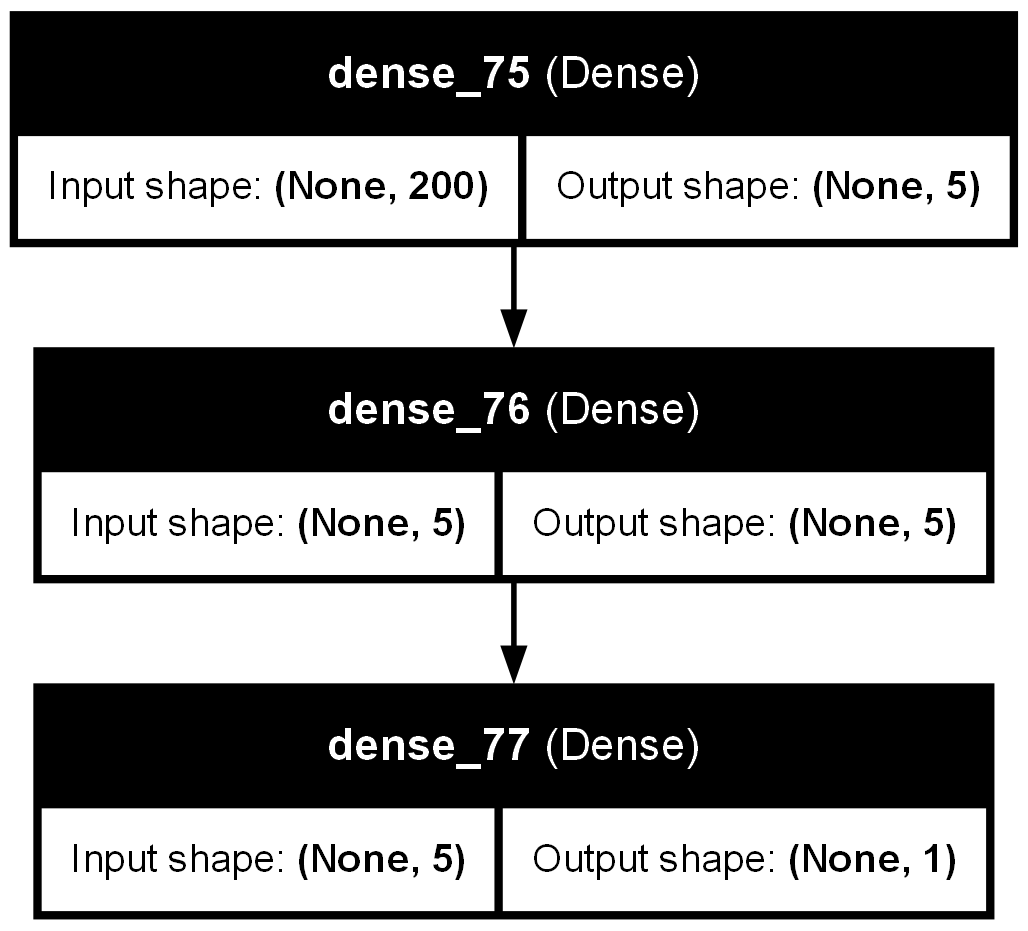

In [47]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

reg = tf.keras.regularizers.l2(0.0001)

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(5, activation='relu', input_shape=(X_train.shape[-1],), kernel_regularizer=reg),
        tf.keras.layers.Dense(5, activation='relu', kernel_regularizer=reg),
        tf.keras.layers.Dense(1, activation='linear')
    ]
)

model_scaled = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(5, activation='relu', input_shape=(X_train_scaled.shape[-1],), kernel_regularizer=reg),
        tf.keras.layers.Dense(5, activation='relu', kernel_regularizer=reg),
        tf.keras.layers.Dense(1, activation='linear')
    ]
)

optimizer = tf.keras.optimizers.Adam()
optimizer_scaled = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.MeanSquaredError()
loss_function_scaled = tf.keras.losses.MeanSquaredError()

model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae', 'mse'])
model_scaled.compile(loss=loss_function_scaled, optimizer=optimizer_scaled, metrics=['mae', 'mse'])

model.summary()
# I don't know why this plot is not printing
plot_model(model, show_shapes=True, show_layer_names=True)
model_scaled.summary()
plot_model(model_scaled, show_shapes=True, show_layer_names=True)

In [27]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=512, verbose=1)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0973 - mae: 0.2202 - mse: 0.0958 - val_loss: 0.0228 - val_mae: 0.0998 - val_mse: 0.0212
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163 - mae: 0.0832 - mse: 0.0147 - val_loss: 0.0059 - val_mae: 0.0474 - val_mse: 0.0044
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - mae: 0.0415 - mse: 0.0035 - val_loss: 0.0037 - val_mae: 0.0319 - val_mse: 0.0023
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - mae: 0.0299 - mse: 0.0021 - val_loss: 0.0030 - val_mae: 0.0261 - val_mse: 0.0017
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - mae: 0.0250 - mse: 0.0017 - val_loss: 0.0027 - val_mae: 0.0231 - val_mse: 0.0015
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - mae: 0.0219 - mse: 0.0014 - val_loss: 0.0025 - val_mae: 0.0213 - val_mse: 0.0014
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - mae: 0.0207 - mse: 0.0014 - val_loss: 

In [48]:
history_scaled = model_scaled.fit(X_train_scaled, y_train_scaled, validation_data=(X_valid_scaled, y_valid_scaled), epochs=100, batch_size=512, verbose=1)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0266 - mae: 0.6929 - mse: 1.0253 - val_loss: 0.7038 - val_mae: 0.5276 - val_mse: 0.7024
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6202 - mae: 0.4842 - mse: 0.6188 - val_loss: 0.4268 - val_mae: 0.3650 - val_mse: 0.4253
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3547 - mae: 0.3301 - mse: 0.3531 - val_loss: 0.2321 - val_mae: 0.2529 - val_mse: 0.2304
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2024 - mae: 0.2319 - mse: 0.2007 - val_loss: 0.1489 - val_mae: 0.1949 - val_mse: 0.1471
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1440 - mae: 0.1875 - mse: 0.1422 - val_loss: 0.1049 - val_mae: 0.1604 - val_mse: 0.1030
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1056 - mae: 0.1568 - mse: 0.1038 - val_loss: 0.0946 - val_mae: 0.1424 - val_mse: 0.0928
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1037 - mae: 0.1434 - mse: 0.1019 - val_loss: 

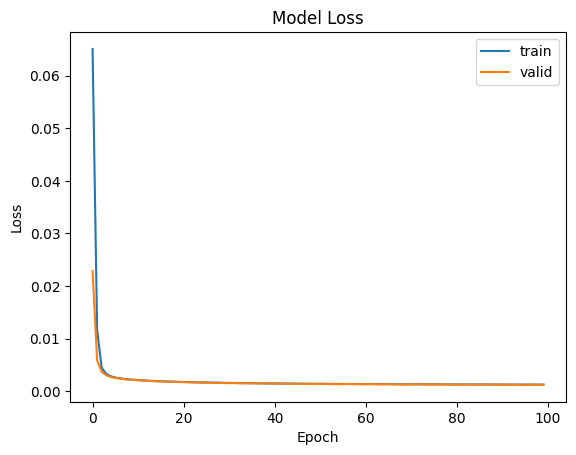

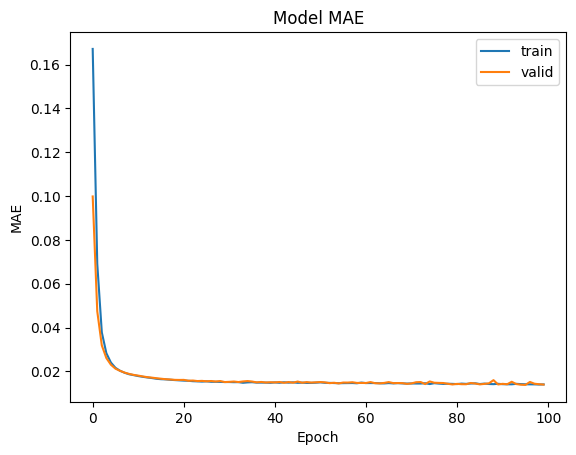

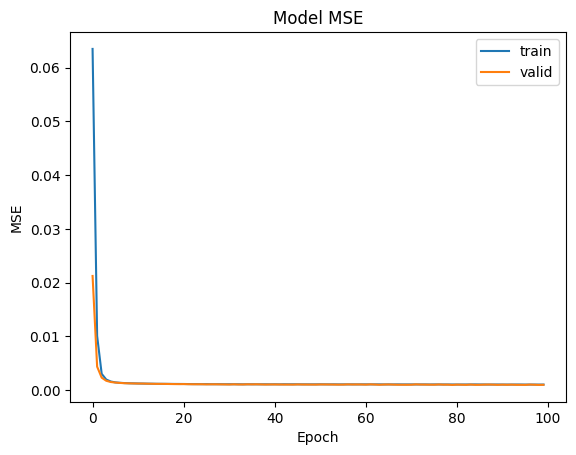

In [30]:
create_training_history_plot(history)

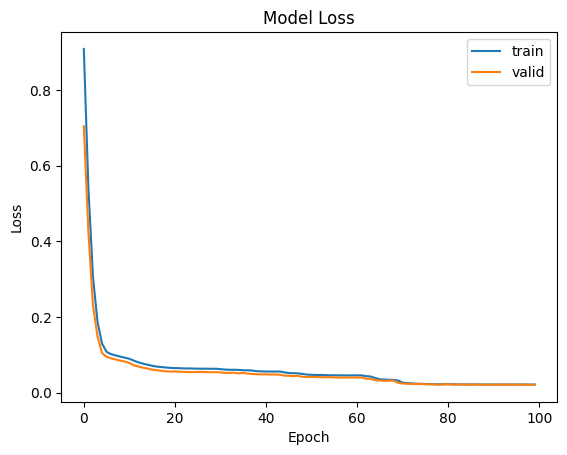

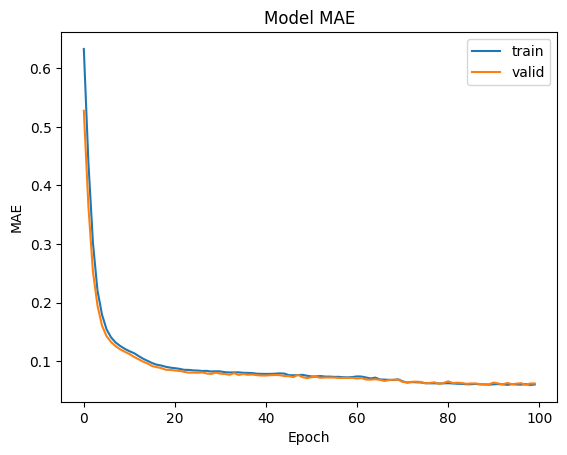

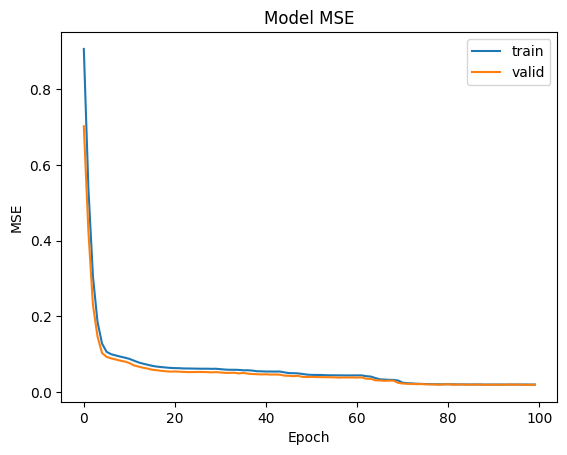

In [49]:
create_training_history_plot(history_scaled)

In [32]:
# Evaluate the model
loss, mae, mse = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Predict the test data
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.0012 - mae: 0.0141 - mse: 9.9264e-04
Loss: 0.0012834783410653472
Mean Absolute Error: 0.014033078216016293
Mean Squared Error: 0.0010298934066668153
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean absolute error: 0.014033088347904916
Mean squared error: 0.001029893890026511
Mean relative error: 0.5568692370142578


In [50]:
# Evaluate the model (scaled)
loss, mae, mse = model_scaled.evaluate(X_test_scaled, y_test_scaled)
print(f"Loss: {loss}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Predict the test data (scaled)
y_pred_scaled = model_scaled.predict(X_test_scaled)

# Print full regression report (scaled)
print_full_regression_report(y_test_scaled, y_pred_scaled)

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 0.0208 - mae: 0.0606 - mse: 0.0189
Loss: 0.02147088199853897
Mean Absolute Error: 0.060514166951179504
Mean Squared Error: 0.019578998908400536
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
Mean absolute error: 0.060514168059186045
Mean squared error: 0.019579002753218333
Mean relative error: 0.26157287201944257


c:\Users\Fral0\Desktop\Workbench\progetto-piccialli\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_62 (Dense)                │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,593 (744.50 KB)

 Trainable params: 190,593 (744.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_67 (Dense)                │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,593 (744.50 KB)

 Trainable params: 190,593 (744.50 KB)

 Non-trainable params: 0 (0.00 B)

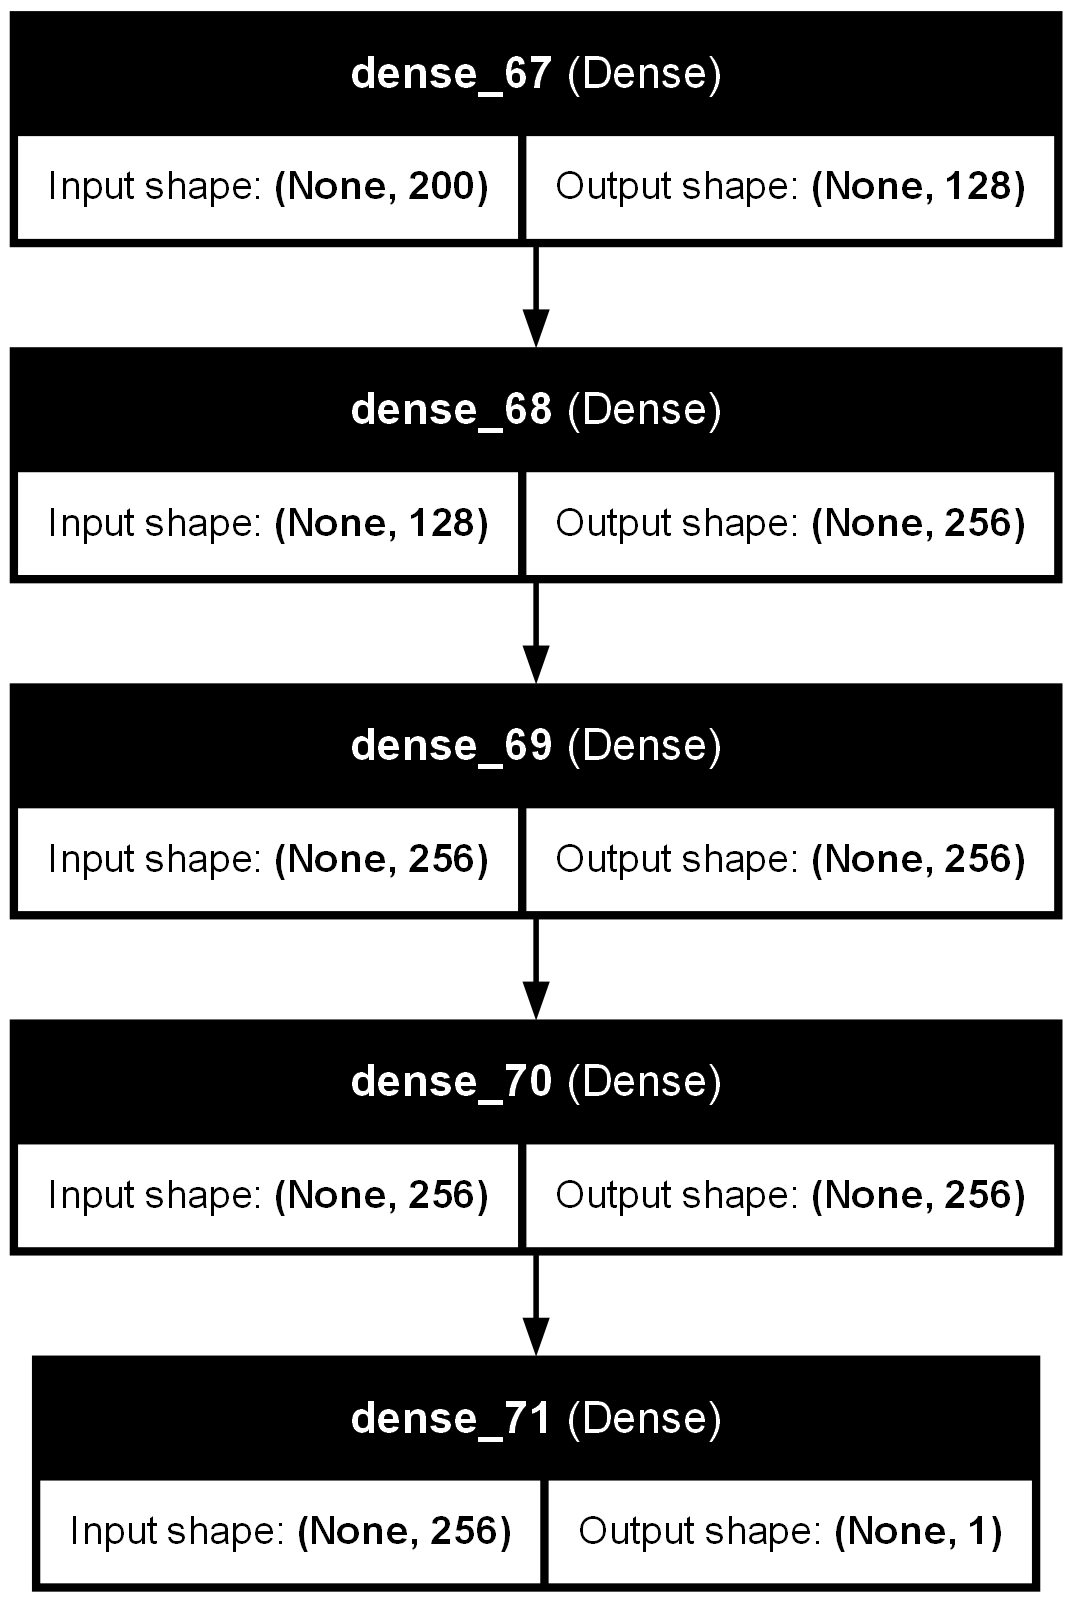

In [40]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Define the regularizer
reg = tf.keras.regularizers.l2(0.0001)

# Define the model
model2 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, activation='relu', input_shape=(200,), kernel_initializer='normal', kernel_regularizer=reg),
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer='normal', kernel_regularizer=reg),
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer='normal', kernel_regularizer=reg),
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer='normal', kernel_regularizer=reg),
        tf.keras.layers.Dense(1, activation='linear', kernel_initializer='normal', kernel_regularizer=reg)
    ]
)
model2_scaled = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, activation='relu', input_shape=(200,), kernel_initializer='normal', kernel_regularizer=reg),
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer='normal', kernel_regularizer=reg),
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer='normal', kernel_regularizer=reg),
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer='normal', kernel_regularizer=reg),
        tf.keras.layers.Dense(1, activation='linear', kernel_initializer='normal', kernel_regularizer=reg)
    ]
)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()
optimizer_scaled = tf.keras.optimizers.Adam()

# Define the loss function
loss_function = tf.keras.losses.MeanAbsoluteError()
loss_function_scaled = tf.keras.losses.MeanAbsoluteError()

# Compile the model
model2.compile(loss=loss_function, optimizer=optimizer, metrics=['mae', 'mse'])
model2_scaled.compile(loss=loss_function_scaled, optimizer=optimizer_scaled, metrics=['mae', 'mse'])

# Print the model summary
model2.summary()
# I don't know why this plot is not printing
plot_model(model2, show_shapes=True, show_layer_names=True)
model2_scaled.summary()
plot_model(model2_scaled, show_shapes=True, show_layer_names=True)

In [41]:
history2 = model2.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=1024, verbose=1)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2530 - mae: 0.2089 - mse: 0.0924 - val_loss: 0.0696 - val_mae: 0.0343 - val_mse: 0.0061
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0591 - mae: 0.0260 - mse: 0.0034 - val_loss: 0.0438 - val_mae: 0.0160 - val_mse: 0.0012
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0416 - mae: 0.0151 - mse: 0.0011 - val_loss: 0.0379 - val_mae: 0.0146 - val_mse: 0.0011
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0364 - mae: 0.0140 - mse: 0.0011 - val_loss: 0.0337 - val_mae: 0.0134 - val_mse: 9.6067e-04
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0327 - mae: 0.0129 - mse: 0.0011 - val_loss: 0.0313 - val_mae: 0.0132 - val_mse: 9.4475e-04
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0301 - mae: 0.0124 - mse: 9.2533e-04 - val_loss: 0.0300 - val_mae: 0.0135 - val_mse: 9.5856e-04
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0284 - mae: 0.0123 - mse: 9.

In [42]:
history2_scaled = model2_scaled.fit(X_train_scaled, y_train_scaled, validation_data=(X_valid_scaled, y_valid_scaled), epochs=100, batch_size=1024, verbose=1)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5720 - mae: 0.5258 - mse: 0.9466 - val_loss: 0.2164 - val_mae: 0.1736 - val_mse: 0.2080
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1536 - mae: 0.1117 - mse: 0.0739 - val_loss: 0.1008 - val_mae: 0.0617 - val_mse: 0.0206
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0959 - mae: 0.0576 - mse: 0.0199 - val_loss: 0.0918 - val_mae: 0.0558 - val_mse: 0.0180
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0872 - mae: 0.0518 - mse: 0.0173 - val_loss: 0.0889 - val_mae: 0.0554 - val_mse: 0.0180
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0885 - mae: 0.0555 - mse: 0.0193 - val_loss: 0.0831 - val_mae: 0.0515 - val_mse: 0.0172
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0811 - mae: 0.0500 - mse: 0.0170 - val_loss: 0.0795 - val_mae: 0.0497 - val_mse: 0.0170
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0802 - mae: 0.0507 - mse: 0.0191 - val_loss:

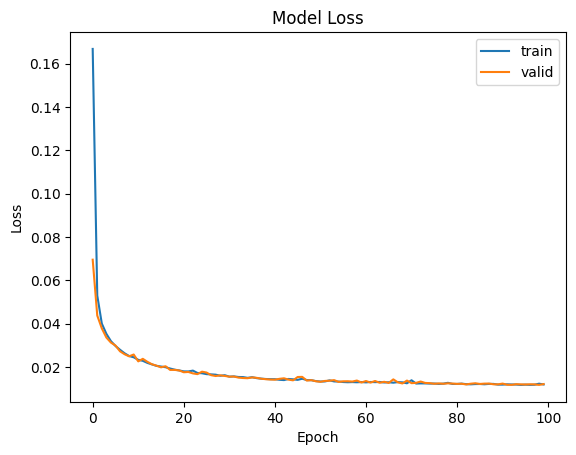

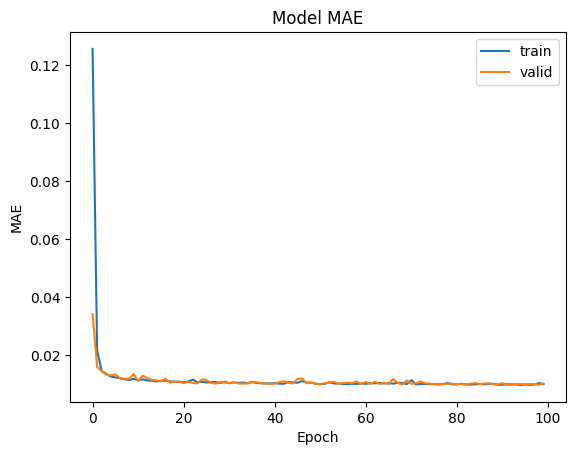

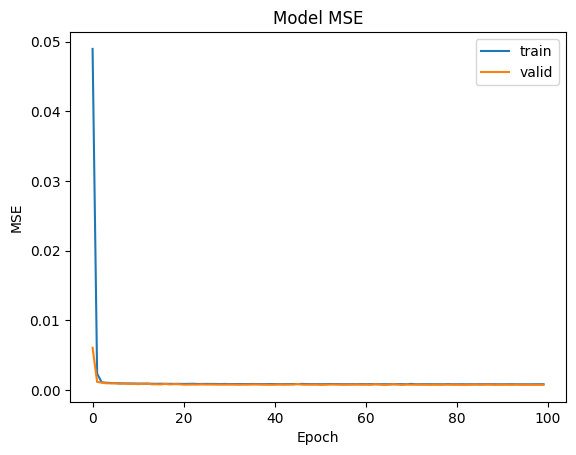

In [43]:
create_training_history_plot(history2)

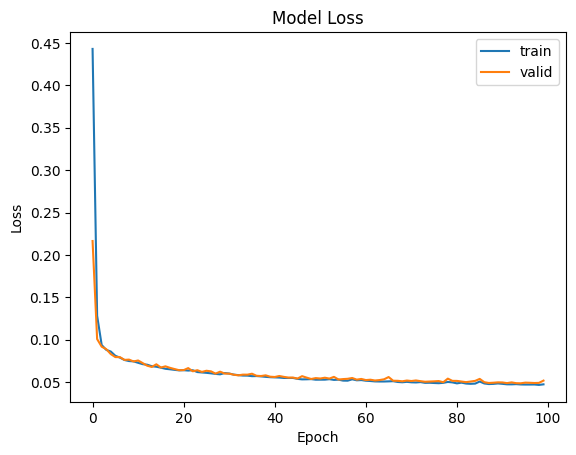

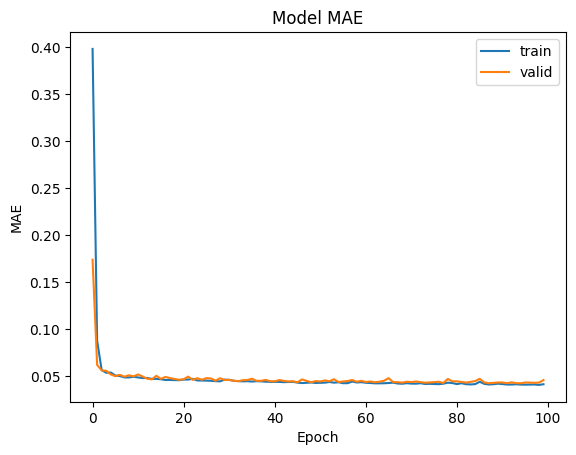

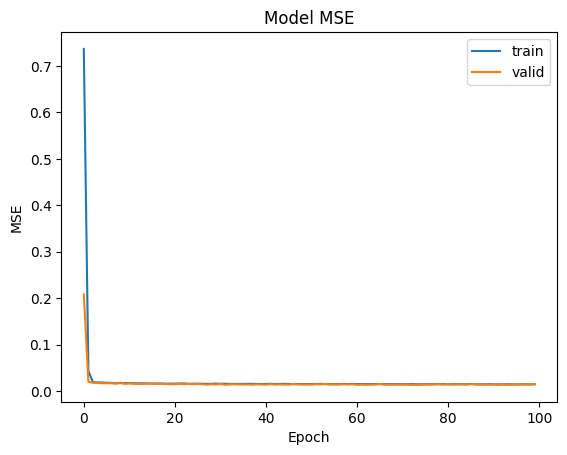

In [44]:
create_training_history_plot(history2_scaled)

In [45]:
# Evaluate the model
loss, mae, mse = model2.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Predict the test data
y_pred = model2.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 0.0126 - mae: 0.0107 - mse: 8.3325e-04
Loss: 0.012477747164666653
Mean Absolute Error: 0.010620707646012306
Mean Squared Error: 0.0008658080478198826
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean absolute error: 0.01062070876892364
Mean squared error: 0.0008658081075751859
Mean relative error: 0.5640006936053952


In [46]:
# Evaluate the model (scaled)
loss, mae, mse = model2_scaled.evaluate(X_test_scaled, y_test_scaled)
print(f"Loss: {loss}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Predict the test data (scaled)
y_pred_scaled = model2_scaled.predict(X_test_scaled)

# Print full regression report (scaled)
print_full_regression_report(y_test_scaled, y_pred_scaled)

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0525 - mae: 0.0462 - mse: 0.0169  
Loss: 0.05223681032657623
Mean Absolute Error: 0.04595597833395004
Mean Squared Error: 0.01755412295460701
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean absolute error: 0.045955985951495415
Mean squared error: 0.0175541152528733
Mean relative error: 0.17359158777518655


# Classification from Regression

In [66]:
# Take classification data from pickle files
X_train = pickle.load(open('X_train_classification.pkl', 'rb'))
X_test = pickle.load(open('X_test_classification.pkl', 'rb'))
y_train = pickle.load(open('y_train_classification.pkl', 'rb'))
y_test = pickle.load(open('y_test_classification.pkl', 'rb'))

In [67]:
from sklearn.base import BaseEstimator, ClassifierMixin

class RegressionClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, regressor_model, intervals, classes_map = None):
        self.model = regressor_model
        self.intervals = intervals

        if classes_map is None:
            self.classes_map = {i: i for i in range(len(intervals) - 1)}
        else:
            self.classes_map = classes_map

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        y_pred = self.model.predict(X)
        y_pred_class = np.zeros_like(y_pred)
        for i in range(len(self.intervals) - 1):
            # Note: mask is a vector of booleans
            mask = (y_pred >= self.intervals[i]) & (y_pred < self.intervals[i + 1])
            y_pred_class[mask] = self.classes_map[i]
        return y_pred_class

Accuracy: 0.9894388906804257
Scatter plot of the test data:


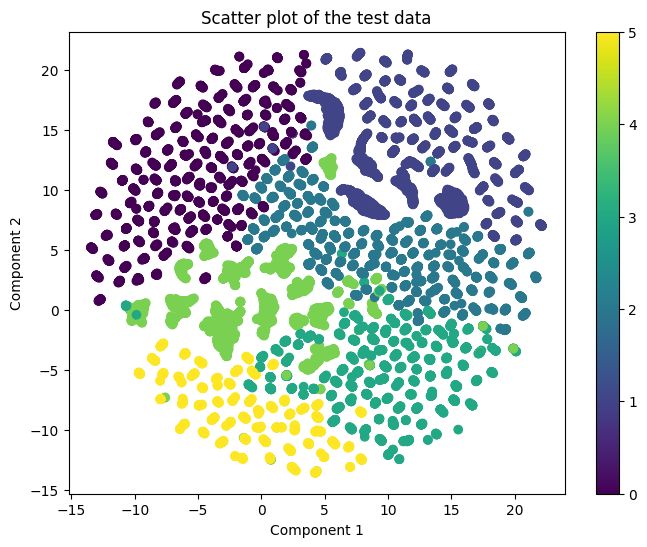

Confusion matrix:


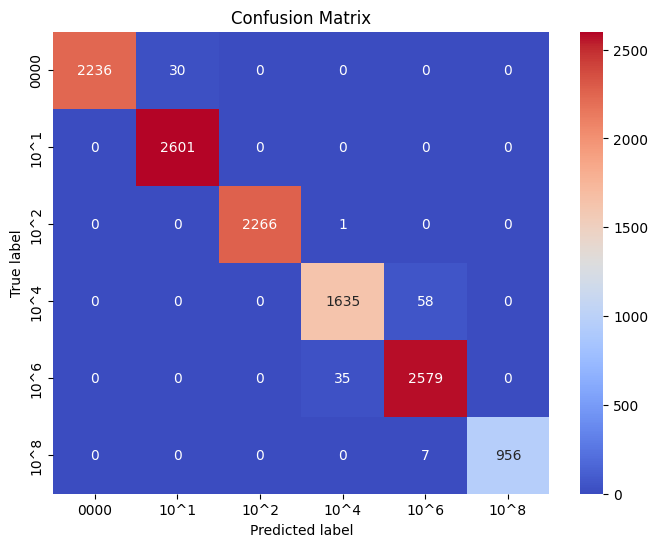

Classification Report:
              precision    recall  f1-score   support

        0000       1.00      0.99      0.99      2266
        10^1       0.99      1.00      0.99      2601
        10^2       1.00      1.00      1.00      2267
        10^4       0.98      0.97      0.97      1693
        10^6       0.98      0.99      0.98      2614
        10^8       1.00      0.99      1.00       963

    accuracy                           0.99     12404
   macro avg       0.99      0.99      0.99     12404
weighted avg       0.99      0.99      0.99     12404



In [70]:
# Import the data
import pickle
from sklearn.neighbors import KNeighborsRegressor

X_classification = pickle.load(open('X_classification.pkl', 'rb'))
X_train_classification = pickle.load(open('X_train_classification.pkl', 'rb'))
X_test_classification = pickle.load(open('X_test_classification.pkl', 'rb'))
y_classification = pickle.load(open('y_classification.pkl', 'rb'))
y_train_classification = pickle.load(open('y_train_classification.pkl', 'rb'))
y_test_classification = pickle.load(open('y_test_classification.pkl', 'rb'))

X_regression = pickle.load(open('X_regression.pkl', 'rb'))
X_train_regression = pickle.load(open('X_train_regression.pkl', 'rb'))
X_test_regression = pickle.load(open('X_test_regression.pkl', 'rb'))
y_regression = pickle.load(open('y_classification.pkl', 'rb'))
y_train_regression = pickle.load(open('y_train_regression.pkl', 'rb'))
y_test_regression = pickle.load(open('y_test_regression.pkl', 'rb'))

# Train the model
regressor_model = KNeighborsRegressor(n_neighbors=7)

classifier_intervals = [0, 0.225, 0.28, 0.35, 0.42, 0.75, 1.5]
classifier_model = RegressionClassifier(regressor_model, classifier_intervals)

classifier_model.fit(X_train_regression, y_train_regression)

# Predict the classes
y_pred_classification = classifier_model.predict(X_test_classification)

# Print full classification report
print_full_classification_report(y_test_classification, y_pred_classification, X_test=X_test, target_names=CLASSES_SHORT)
